In [ ]:
import numpy as np
import pandas as pd
import numpy as np

def benchmark(x1, x2):
    return (    (1.3356 * (1.5 * (1 - x1))) 
                + (np.exp((2 * x1) - 1) * np.sin((3 * np.pi) * ((x1 - 0.6) ** 2)))
                + (np.exp(3 * (x2 - 0.5)) * np.sin((4 * np.pi) * ((x2 - 0.9) ** 2)))
            )

# Gera dados aleatórios ao invés de um grid regular
def GetRandomSamples(n_samples):
    x = np.random.uniform(0, 1, n_samples)
    y = np.random.uniform(0, 1, n_samples)
    z = benchmark(x, y)
    return x, y, z

# Cria um DataFrame a partir dos pontos aleatórios
def create_random_dataframe(n_samples):
    x, y, z = GetRandomSamples(n_samples)
    data = {'x1': x, 'x2': y, 'f(x1,x2)': z}
    df = pd.DataFrame(data)
    return df

def GetGrid(grid):
    x = np.linspace(0, 1, grid)
    y = np.linspace(0, 1, grid)
    x, y = np.meshgrid(x, y)
    z = benchmark(x, y)
    return x, y, z

def create_dataframe(grid):
   x, y, z = GetGrid(grid)
   data = {'x1': x.flatten(), 'x2': y.flatten(), 'f(x1,x2)': z.flatten()}
   df = pd.DataFrame(data)
   return df


df_1000 = create_dataframe(32)
df_training = create_random_dataframe(n_samples=30)   
df_test = create_random_dataframe(n_samples=20)       
df_virtual = pd.read_excel("../VirtualSamples.xlsx", sheet_name="Gaussian")

/tmp/ipykernel_11482/4088581831.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


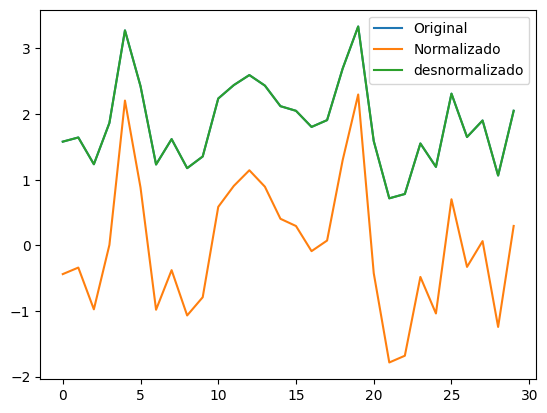

In [ ]:
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

scaler = StandardScaler()
out_scaler = StandardScaler()

def show_norm(df, label="data", plot=False):
    df_norm = pd.DataFrame(scaler.transform(df), columns=df.columns)
    df_denorm = pd.DataFrame(scaler.inverse_transform(df_norm), columns=df_norm.columns)

    if (plot):
        df.plot(title=f"{label}: Original data")
        df_norm.plot(title=f"{label}: Normalized data")
        df_denorm.plot(title=f"{label}: Denormalized data")
    return (df_norm)


def test_out_scaler(df):
    out = df["f(x1,x2)"].values.reshape(-1, 1)  
    plt.plot(out, label='Original')
    out_scaler.fit(out)
    norm = out_scaler.transform(out)
    plt.plot(norm, label='Normalizado')
    plt.plot(out_scaler.inverse_transform(norm), label='desnormalizado')
    plt.legend()
    plt.show()

scaler.fit(df_training)
test_out_scaler(df_training)

df_training_norm = show_norm(df_training, "Training")
df_1000_norm = show_norm(df_1000)
df_test_norm = show_norm(df_test)
df_virtual_norm = show_norm(pd.concat([df_training, df_virtual]))

In [ ]:
import os

os.chdir("./content")

lm_dir = "tf-levenberg-marquardt"
if not os.path.exists(lm_dir):
  !git clone https://github.com/fabiodimarco/$lm_dir

os.chdir(lm_dir)

Cloning into 'tf-levenberg-marquardt'...
remote: Enumerating objects: 53, done.
remote: Counting objects: 100% (53/53), done.
remote: Compressing objects: 100% (38/38), done.
remote: Total 53 (delta 31), reused 29 (delta 14), pack-reused 0 (from 0)
Receiving objects: 100% (53/53), 32.99 KiB | 6.60 MiB/s, done.
Resolving deltas: 100% (31/31), done.


In [4]:
def split_df(df):
    _input = np.vstack([df['x1'], df['x2']]).T
    _output = np.array(df['f(x1,x2)'])
    return (_input, _output)

In [5]:
import tensorflow as tf
import numpy as np
from keras import regularizers
from keras import initializers
import levenberg_marquardt as lm

# layers, neurons
class ShuffleArchitecture:
    def __init__(self, input_size, hidden_sizes, output_size, act_h, act_o, param_reg):
        self.input_size = input_size
        self.hidden_sizes = hidden_sizes
        self.output_size = output_size
        self.act_h = act_h
        self.act_o = act_o
        self.regularizer = regularizers.L2(param_reg)
        self.initializer = initializers.RandomUniform(minval=-0.5, maxval=0.5, seed=np.random.randint(1, 10000))

    def compute_k(self):
        total_parameters = 0
        for layer in self.model.layers:
            weights = layer.get_weights()
            if len(weights) > 0:  
                for w in weights:
                    total_parameters += np.prod(w.shape)
        return total_parameters
        
    def set_architecture(self):
        self.model = tf.keras.Sequential()
        self.model.add(tf.keras.layers.Dense(self.hidden_sizes[0],
                        input_shape=(self.input_size,),
                        activation=self.act_h,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,                        
                        ))  # input layer

        for size in self.hidden_sizes[1:]:  # hidden layers
            self.model.add(tf.keras.layers.Dense(size,
                            activation=self.act_h,
                            kernel_regularizer=self.regularizer,
                            kernel_initializer=self.initializer,  
                        ))

        self.model.add(tf.keras.layers.Dense(self.output_size,
                        activation=self.act_o,
                        kernel_regularizer=self.regularizer,
                        kernel_initializer=self.initializer,  
                        ))  # output layer

    def create_model(self, _learning_rate):
        self.model.compile(
            optimizer=tf.keras.optimizers.Adam(learning_rate=_learning_rate),
            loss=tf.keras.losses.MeanSquaredError())

        self.lm_model = lm.ModelWrapper(
            tf.keras.models.clone_model(self.model))

        self.lm_model.compile(
            optimizer=tf.keras.optimizers.SGD(learning_rate=_learning_rate),
            loss=lm.MeanSquaredError())
        return(self.lm_model)

2024-10-14 14:22:56.021880: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-10-14 14:22:56.021930: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-10-14 14:22:56.055356: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-10-14 14:22:56.762364: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-10-14 14:23:03.017933: W tensorflow/compiler/tf2

In [6]:
from sklearn.model_selection import train_test_split
from keras.callbacks import EarlyStopping
from sklearn.metrics import r2_score, mean_squared_error, root_mean_squared_error, mean_absolute_percentage_error 

class TrainWithSmallDataset:
    def __init__(self, batch_size=1000):
        self.batch_size = batch_size
        self.betters = []
        self.k = 0

    def create_dataset(self, input, output):
      input = tf.expand_dims(tf.cast(input, tf.float32), axis=-1)
      output = tf.expand_dims(tf.cast(output, tf.float32), axis=-1)
      dataset = tf.data.Dataset.from_tensor_slices((input, output))
      dataset = dataset.shuffle(len(input))
      dataset = dataset.batch(self.batch_size).cache()
      dataset = dataset.prefetch(tf.data.experimental.AUTOTUNE)
      return (dataset, input, output)

    def split_dataset(self, tester):
      input_train, input_val, output_train, output_val = train_test_split(tester.input, tester.output, test_size=0.2, shuffle = True)

      self.dataset, self.input, self.output = self.create_dataset(tester.input, tester.output)
      self.train_dataset, self.train_input, self.train_output = self.create_dataset(input_train, output_train)
      self.test_dataset, self.test_input, self.test_output = self.create_dataset(tester.input_test, tester.output_test)
      self.val_dataset, self.val_input, self.val_output = self.create_dataset(input_val, output_val)
      self.sup_dataset, self.sup_input, self.sup_output = self.create_dataset(tester.input_1000, tester.output_1000)

      self._train = (input_train, output_train)
      self._val = (input_val, output_val)
      self._test = (tester.input_test, tester.output_test)
      self._data = (tester.input, tester.output)
      self._sup = (tester.input_1000, tester.output_1000)


    def train_using_lm(self, train_dataset, epochs=1000):
      early_stopping_monitor = EarlyStopping(monitor='val_loss',
                                              patience=6,
                                              restore_best_weights=True)
      
      self.lm_model.save_weights('./initial-.weights.h5')
      self.results = self.lm_model.fit(train_dataset,
                                            epochs=epochs,
                                            validation_data=self.val_dataset,
                                            callbacks=[early_stopping_monitor],
                                            verbose=0)
      print ("Stopped at epoch: ", early_stopping_monitor.stopped_epoch)
    
    def get_new_metrics(self, orig, pred, r2, mse):
      n = len(orig) # N: quantidade de saidas
      k = self.k
      waste = (orig.flatten() - pred.flatten())

      mape = mean_absolute_percentage_error(orig, pred)  
      r2_adj = 1 - (((n - 1)/(n - k - 1)) * (1 - r2))
      rsd = np.sqrt(np.sum(waste ** 2) / (n - 2))
      rmse = root_mean_squared_error(orig, pred)          
      aic = (-2 * np.log(mse)) + (2 * k)
      bic = (-2 * np.log(mse)) + (k * np.log(n))
      return (mape, r2_adj, rsd, rmse, aic, bic)
      

    def get_metrics(self):
          # Calculando a saida com os dados normalizados
          pred = self.lm_model.predict(self.input).flatten()
          test_pred = self.lm_model.predict(self.test_input).flatten()
          val_pred = self.lm_model.predict(self.val_input).flatten()
          sup_pred = self.lm_model.predict(self.sup_input).flatten()

          # Calculando as metricas com a saida desnormalizada
          pred_denorm = out_scaler.inverse_transform(pred.reshape(-1, 1))
          test_pred_denorm = out_scaler.inverse_transform(test_pred.reshape(-1, 1))
          val_pred_denorm = out_scaler.inverse_transform(val_pred.reshape(-1, 1))
          sup_pred_denorm = out_scaler.inverse_transform(sup_pred.reshape(-1, 1))

          out_denorm = out_scaler.inverse_transform(self._data[1].reshape(-1, 1))
          test_denorm = out_scaler.inverse_transform(self._test[1].reshape(-1, 1))
          val_denorm = out_scaler.inverse_transform(self._val[1].reshape(-1, 1))
          sup_denorm = out_scaler.inverse_transform(self._sup[1].reshape(-1, 1))

          r2 = r2_score(out_denorm, pred_denorm)
          r2_test = r2_score(test_denorm, test_pred_denorm)
          r2_val = r2_score(val_denorm, val_pred_denorm)
          r2_sup = r2_score(sup_denorm,  sup_pred_denorm)

          mse = mean_squared_error(out_denorm, pred_denorm)
          mse_test = mean_squared_error(test_denorm, test_pred_denorm)
          mse_val = mean_squared_error(val_denorm, val_pred_denorm)
          mse_sup = mean_squared_error(sup_denorm,  sup_pred_denorm)
          
          mape, r2_adj, rsd, rmse, aic, bic = self.get_new_metrics(out_denorm, pred_denorm, r2, mse)
          metrics = {
                          'r2': r2,
                          'r2_sup': r2_sup,
                          'r2_test': r2_test,
                          'r2_val': r2_val,
                          'mse': mse,
                          'mse_sup': mse_sup,
                          'mse_test': mse_test,
                          'mse_val': mse_val,
                          'mape': mape,
                          'rmse': rmse,
                          'r2_adj': r2_adj,
                          'rsd': rsd,
                          'aic': aic,
                          'bic': bic
                          }

          return metrics

In [7]:
import pickle
from itertools import product
import shutil

class Tester:
  def __init__(self, _df, _df_1000, _df_test,  run_times=500, dataset_run_times=10):
    self.run_times = run_times
    self.better_metrics = {}
    self.dataset_run_times = dataset_run_times
    self.input, self.output = split_df(_df)
    self.input_1000, self.output_1000 = split_df(_df_1000)
    self.input_test, self.output_test = split_df(_df_test)
  
  def setArchitecure(self, trainer, _hidden_sizes, _pg, _lr):
    shuffler = ShuffleArchitecture(input_size=2,
                                    hidden_sizes=_hidden_sizes,
                                    output_size=1,
                                    act_h='tanh',
                                    act_o='linear',
                                    param_reg=_pg)
    shuffler.set_architecture()    
    trainer.lm_model = shuffler.create_model(_lr)
    trainer.k = shuffler.compute_k()

  def Train(self, trainer, epochs=1000):
    trainer.train_using_lm(trainer.train_dataset, epochs=epochs)
    return(trainer.get_metrics(), trainer.lm_model)

  def SaveModelWeights(self, model, fileName):
    path = f"../models/{fileName}.keras"
    open(path,'w').close()
    model.save_weights(path)
    shutil.move("./initial-.weights.h5",
                f"../models/initial-weights/{fileName}.keras")

  def SaveDataset(self, trainer, fileName):
    path = f"../dataset/{fileName}.pkl" 
    with open(path, 'wb') as f:
      pickle.dump((trainer._data, trainer._train, trainer._val, trainer._test), f)
      
  def LoopWeights(self, sort_by, boundarie, trainer, idx):
    better_model = 0
    save = False

    for i in range(self.run_times):
      print (f"+++++++++++ [{idx}] | {i + 1} ++++++++++++++++++")
      metrics, model = self.Train(trainer)
      if (metrics[sort_by] <= boundarie): # should be >= to acsending metrics
        fileName = f"model_{idx}_{better_model}"
        self.SaveModelWeights(model, fileName)
        self.better_metrics[fileName] = metrics
        better_model += 1
        save = True
    return(save)

  def Loop(self, sort_by, boundarie, hidden_sizes, regularizers, learning_rate):
    trainer = TrainWithSmallDataset()

    for count, (hidden_size, reg, lr) in enumerate(product(hidden_sizes, regularizers, learning_rate), start=1):
      header =  f"Hidden Size={hidden_size}, regularizer={reg}, learning_rate={lr}"
      print(f"Testando combinacao{count}: {header}")
      self.setArchitecure(trainer, hidden_size, reg, lr)
      for j in range(self.dataset_run_times):
        trainer.split_dataset(self)
        if (self.LoopWeights(sort_by, boundarie, trainer, f"{count}_{j}") == True):
          self.SaveDataset(trainer, f"dataset_{count}_{j}")
          self.DisplayBetterResults('mse_sup', header, f"{count}_{j}")
        self.better_metrics = {}

  def DisplayBetterResults(self, sort_by, header, dataset=0):
    df = pd.DataFrame.from_dict(self.better_metrics, orient='index')
    df = df.sort_values([sort_by])
    display(df)
    path = f'../results/metrics_{dataset}'
    df.to_excel(f"{path}.xlsx", index=True)
    print(f"DataFrame salvo em {path}")
    with open(f"{path}.txt", 'w') as arquivo:
      arquivo.write(header)

# Treinando apenas com dados originais


In [ ]:
tester = Tester(
                _df=df_virtual_norm,
                _df_1000=df_1000_norm,
                _df_test = df_test_norm,
                run_times=10, dataset_run_times=50)
tester.Loop(sort_by='mse',
            boundarie = 0.5,
            hidden_sizes = [[4], [8], [12], [24], [36],
                            [4, 2], [8, 4], [12, 6], [24, 12], [36, 18]],
            regularizers=[0.02],
            learning_rate=[0.01])

Testando combinacao1: Hidden Size=[4], regularizer=0.02, learning_rate=0.01
+++++++++++ [1_0] | 1 ++++++++++++++++++


Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_0] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_0] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_0] | 4 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_0] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_0] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_0] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_0] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_0_9,0.561000,0.491757,0.399311,0.600936,0.185348,0.301715,0.267941,0.129562,0.261975,0.430520,0.497214,0.433745,37.371045,86.760716
model_1_0_8,0.553012,0.484593,0.390069,0.593118,0.188720,0.305968,0.272063,0.132101,0.264230,0.434419,0.488065,0.437674,37.334979,86.724650
model_1_0_7,0.544851,0.477284,0.380611,0.585114,0.192166,0.310307,0.276282,0.134699,0.266506,0.438368,0.478718,0.441651,37.298790,86.688461
model_1_0_6,0.502364,0.462513,0.414350,0.525624,0.210104,0.319075,0.261233,0.154014,0.295040,0.458371,0.430058,0.461805,37.120303,86.509974
model_1_0_5,0.474843,0.439567,0.388296,0.497849,0.221724,0.332697,0.272854,0.163031,0.303351,0.470876,0.398538,0.474403,37.012646,86.402317
model_1_0_4,0.465201,0.431370,0.378607,0.488284,0.225795,0.337564,0.277176,0.166137,0.306109,0.475179,0.387495,0.478738,36.976258,86.365930
model_1_0_3,0.446287,0.416984,0.364589,0.468110,0.233780,0.346103,0.283429,0.172687,0.312328,0.483508,0.365833,0.487130,36.906750,86.296421
model_1_0_2,0.322368,0.315503,0.247307,0.344521,0.286099,0.406347,0.335743,0.212812,0.346517,0.534882,0.223909,0.538889,36.502833,85.892504
model_1_0_1,0.091992,0.165003,0.125604,0.073008,0.383365,0.495690,0.390029,0.300963,0.419011,0.619165,-0.039941,0.623803,35.917535,85.307206
model_1_0_0,-0.014346,0.047997,0.061625,0.041420,0.428261,0.565150,0.418568,0.311219,0.427649,0.654417,-0.161730,0.659319,35.696043,85.085714


DataFrame salvo em ../results/metrics_1_0
+++++++++++ [1_1] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 2ms/step
+++++++++++ [1_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_1] | 9 +++++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_1_9,0.790044,0.684887,0.592274,0.866692,0.088644,0.187065,0.181869,0.063798,0.160797,0.297732,0.759537,0.299962,38.846244,88.235915
model_1_1_8,0.760486,0.662197,0.586456,0.839663,0.101124,0.200534,0.184464,0.076733,0.182536,0.318000,0.725685,0.320382,38.582819,87.972490
model_1_1_7,0.696045,0.610574,0.543556,0.787429,0.128331,0.231180,0.203599,0.101731,0.216626,0.358233,0.651880,0.360917,38.106281,87.495952
model_1_1_6,0.691624,0.607014,0.540381,0.783767,0.130198,0.233293,0.205016,0.103484,0.218713,0.360829,0.646817,0.363532,38.077402,87.467073
model_1_1_5,0.686520,0.602391,0.534757,0.780495,0.132353,0.236038,0.207524,0.105049,0.220556,0.363803,0.640971,0.366528,38.044568,87.434240
model_1_1_4,0.681851,0.598559,0.531110,0.776743,0.134324,0.238313,0.209151,0.106845,0.222633,0.366502,0.635624,0.369248,38.015002,87.404673
model_1_1_3,0.676702,0.594014,0.525849,0.773216,0.136498,0.241011,0.211498,0.108533,0.224568,0.369456,0.629727,0.372224,37.982892,87.372563
model_1_1_2,0.671305,0.589164,0.519951,0.769714,0.138777,0.243890,0.214129,0.110209,0.226474,0.372527,0.623545,0.375318,37.949779,87.339450
model_1_1_1,0.604328,0.529784,0.447041,0.725864,0.167054,0.279141,0.246651,0.131194,0.248804,0.408723,0.546838,0.411784,37.578873,86.968544
model_1_1_0,0.590374,0.517437,0.431458,0.716876,0.172946,0.286470,0.253601,0.135496,0.253081,0.415868,0.530856,0.418983,37.509553,86.899224


DataFrame salvo em ../results/metrics_1_1
+++++++++++ [1_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_2] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_2] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_2] | 9 ++++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_2_9,0.861396,0.760367,0.659336,0.852398,0.058519,0.142256,0.151955,0.052133,0.120980,0.241907,0.841257,0.243719,39.676805,89.066476
model_1_2_8,0.858487,0.756822,0.660988,0.849313,0.059747,0.144361,0.151218,0.053223,0.123830,0.244433,0.837925,0.246264,39.635256,89.024927
model_1_2_7,0.841348,0.737289,0.636858,0.836051,0.066983,0.155956,0.161981,0.057907,0.131660,0.258812,0.818296,0.260750,39.406619,88.796290
model_1_2_6,0.839465,0.735148,0.633931,0.834602,0.067779,0.157227,0.163287,0.058419,0.132399,0.260343,0.816139,0.262293,39.383017,88.772688
model_1_2_5,0.837674,0.733117,0.631249,0.833201,0.068535,0.158434,0.164484,0.058913,0.133133,0.261791,0.814089,0.263752,39.360834,88.750505
model_1_2_4,0.835844,0.731044,0.628508,0.831765,0.069307,0.159664,0.165706,0.059421,0.133875,0.263263,0.811992,0.265235,39.338405,88.728076
model_1_2_3,0.821703,0.715489,0.609453,0.820557,0.075278,0.168898,0.174206,0.063379,0.139868,0.274368,0.795796,0.276423,39.173138,88.562809
model_1_2_2,0.820019,0.714926,0.621461,0.816492,0.075989,0.169232,0.168850,0.064815,0.145131,0.275660,0.793868,0.277725,39.154344,88.544016
model_1_2_1,0.819567,0.714626,0.622921,0.815758,0.076180,0.169410,0.168198,0.065074,0.146073,0.276007,0.793350,0.278074,39.149318,88.538990
model_1_2_0,0.800759,0.693916,0.594684,0.801397,0.084120,0.181704,0.180794,0.070147,0.152593,0.290035,0.771810,0.292208,38.951014,88.340685


DataFrame salvo em ../results/metrics_1_2
+++++++++++ [1_3] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_3] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_3] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_3] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 21ms/step
+++++++++++ [1_3] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_3] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_3_9,0.891968,0.793623,0.705407,0.868615,0.045612,0.122514,0.131405,0.066810,0.104278,0.213569,0.876271,0.215168,40.175190,89.564861
model_1_3_8,0.891092,0.792592,0.703806,0.867281,0.045982,0.123126,0.132119,0.067489,0.104734,0.214433,0.875268,0.216039,40.159031,89.548702
model_1_3_7,0.889670,0.790946,0.701416,0.865119,0.046582,0.124104,0.133185,0.068588,0.105537,0.215828,0.873639,0.217445,40.133087,89.522758
model_1_3_6,0.888447,0.789545,0.699524,0.863267,0.047098,0.124935,0.134029,0.069530,0.106274,0.217021,0.872238,0.218647,40.111037,89.500708
model_1_3_5,0.879929,0.779845,0.684598,0.850433,0.050695,0.130694,0.140687,0.076056,0.110585,0.225155,0.862483,0.226841,39.963874,89.353545
model_1_3_4,0.875857,0.775334,0.679251,0.844481,0.052414,0.133371,0.143072,0.079083,0.113135,0.228941,0.857819,0.230656,39.897166,89.286837
model_1_3_3,0.874818,0.774167,0.677482,0.842949,0.052853,0.134064,0.143861,0.079862,0.113639,0.229897,0.856629,0.231619,39.880498,89.270169
model_1_3_2,0.873776,0.772998,0.675717,0.841415,0.053292,0.134758,0.144648,0.080642,0.114142,0.230851,0.855436,0.232581,39.863926,89.253597
model_1_3_1,0.872029,0.771169,0.673728,0.838875,0.054030,0.135844,0.145535,0.081933,0.115250,0.232443,0.853435,0.234185,39.836434,89.226105
model_1_3_0,0.865771,0.764654,0.664821,0.829655,0.056672,0.139712,0.149508,0.086622,0.118550,0.238059,0.846267,0.239842,39.740945,89.130617


DataFrame salvo em ../results/metrics_1_3
+++++++++++ [1_4] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_4] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_4] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_4] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_4] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_4] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_4_9,0.923078,0.840077,0.761383,0.926620,0.032477,0.094937,0.106436,0.034680,0.087313,0.180213,0.911901,0.181563,40.854459,90.244130
model_1_4_8,0.922704,0.839441,0.760513,0.926295,0.032635,0.095315,0.106825,0.034834,0.087538,0.180651,0.911473,0.182004,40.844751,90.234423
model_1_4_7,0.915154,0.826830,0.746175,0.920087,0.035822,0.102801,0.113220,0.037768,0.092241,0.189268,0.902826,0.190686,40.658359,90.048030
model_1_4_6,0.914576,0.825951,0.744975,0.919508,0.036066,0.103323,0.113756,0.038041,0.092543,0.189911,0.902164,0.191334,40.644791,90.034462
model_1_4_5,0.912237,0.822360,0.740625,0.917282,0.037054,0.105455,0.115696,0.039093,0.093797,0.192494,0.899485,0.193936,40.590769,89.980440
model_1_4_4,0.907889,0.815854,0.732634,0.912908,0.038890,0.109317,0.119260,0.041161,0.095936,0.197205,0.894505,0.198682,40.494055,89.883726
model_1_4_3,0.906580,0.813839,0.730601,0.911651,0.039442,0.110513,0.120167,0.041755,0.096709,0.198601,0.893007,0.200088,40.465840,89.855511
model_1_4_2,0.905888,0.812835,0.729297,0.910899,0.039734,0.111109,0.120749,0.042110,0.097092,0.199335,0.892214,0.200828,40.451076,89.840747
model_1_4_1,0.901019,0.805875,0.720599,0.905605,0.041790,0.115241,0.124628,0.044612,0.099740,0.204427,0.886637,0.205958,40.350176,89.739847
model_1_4_0,0.893751,0.796020,0.708381,0.897513,0.044859,0.121091,0.130079,0.048437,0.103425,0.211799,0.878313,0.213386,40.208465,89.598136


DataFrame salvo em ../results/metrics_1_4
+++++++++++ [1_5] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_5] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_5] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_5] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_5_9,0.935006,0.860818,0.785503,0.907969,0.027441,0.082624,0.095677,0.036531,0.077123,0.165652,0.925563,0.166893,41.191455,90.581126
model_1_5_8,0.934328,0.859349,0.783628,0.907529,0.027727,0.083496,0.096514,0.036706,0.077615,0.166515,0.924785,0.167762,41.170682,90.560353
model_1_5_7,0.932538,0.855786,0.779022,0.906128,0.028483,0.085612,0.098568,0.037262,0.078949,0.168768,0.922736,0.170032,41.116927,90.506599
model_1_5_6,0.931192,0.853385,0.775571,0.904769,0.029051,0.087037,0.100108,0.037801,0.079925,0.170444,0.921194,0.171721,41.077398,90.467070
model_1_5_5,0.930780,0.852514,0.775076,0.904708,0.029225,0.087554,0.100329,0.037826,0.080356,0.170953,0.920723,0.172233,41.065469,90.455140
model_1_5_4,0.929788,0.850650,0.773711,0.904271,0.029644,0.088661,0.100937,0.037999,0.081294,0.172173,0.919587,0.173463,41.037014,90.426685
model_1_5_3,0.926675,0.845810,0.766696,0.900650,0.030958,0.091534,0.104067,0.039437,0.083540,0.175949,0.916021,0.177267,40.950240,90.339911
model_1_5_2,0.925990,0.844888,0.766449,0.900203,0.031247,0.092081,0.104177,0.039614,0.084579,0.176769,0.915236,0.178094,40.931635,90.321306
model_1_5_1,0.925143,0.843668,0.765754,0.899649,0.031605,0.092805,0.104487,0.039834,0.085790,0.177777,0.914267,0.179109,40.908893,90.298564
model_1_5_0,0.924923,0.843339,0.765371,0.899434,0.031698,0.093001,0.104658,0.039919,0.086013,0.178039,0.914015,0.179372,40.903019,90.292690


DataFrame salvo em ../results/metrics_1_5
+++++++++++ [1_6] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_6] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_6] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_6] | 4 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_6] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_6] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_6] | 9 +++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_6_9,0.938121,0.868055,0.794690,0.965048,0.026125,0.078328,0.091580,0.012813,0.075724,0.161634,0.929131,0.162844,41.289694,90.679366
model_1_6_8,0.938058,0.867884,0.794463,0.965032,0.026152,0.078430,0.091681,0.012819,0.075748,0.161716,0.929058,0.162928,41.287647,90.677318
model_1_6_7,0.938045,0.867827,0.794454,0.965038,0.026158,0.078463,0.091685,0.012817,0.075761,0.161734,0.929043,0.162945,41.287212,90.676883
model_1_6_6,0.938028,0.867764,0.794431,0.965043,0.026165,0.078501,0.091695,0.012815,0.075775,0.161755,0.929024,0.162967,41.286686,90.676358
model_1_6_5,0.937684,0.866844,0.793399,0.964959,0.026310,0.079047,0.092156,0.012846,0.075906,0.162204,0.928629,0.163419,41.275599,90.665270
model_1_6_4,0.937609,0.866655,0.793147,0.964934,0.026342,0.079160,0.092268,0.012855,0.075933,0.162301,0.928544,0.163517,41.273201,90.662873
model_1_6_3,0.937536,0.866469,0.792902,0.964910,0.026373,0.079270,0.092377,0.012864,0.075959,0.162397,0.928460,0.163613,41.270851,90.660523
model_1_6_2,0.937275,0.865822,0.792109,0.964820,0.026483,0.079654,0.092731,0.012897,0.076049,0.162735,0.928162,0.163954,41.262535,90.652206
model_1_6_1,0.936772,0.864601,0.790605,0.964619,0.026695,0.080378,0.093402,0.012971,0.076280,0.163386,0.927585,0.164610,41.246560,90.636231
model_1_6_0,0.935811,0.862529,0.787559,0.964101,0.027101,0.081609,0.094761,0.013160,0.076738,0.164623,0.926485,0.165856,41.216383,90.606054


DataFrame salvo em ../results/metrics_1_6
+++++++++++ [1_7] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_7] | 2 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_7] | 6 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_7] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_7] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_7_0,0.938141,0.867961,0.794523,0.930221,0.026117,0.078384,0.091654,0.030183,0.075694,0.161608,0.929153,0.162819,41.290325,90.679997
model_1_7_1,0.937979,0.866882,0.792463,0.927586,0.026185,0.079025,0.092573,0.031323,0.075579,0.161819,0.928968,0.163031,41.285104,90.674776
model_1_7_2,0.938006,0.866871,0.792424,0.927372,0.026174,0.079031,0.092590,0.031415,0.075545,0.161784,0.928998,0.162996,41.285963,90.675634
model_1_7_3,0.937916,0.866643,0.791972,0.926886,0.026212,0.079166,0.092792,0.031625,0.075551,0.161901,0.928895,0.163114,41.283070,90.672741
model_1_7_4,0.937877,0.866341,0.791301,0.925799,0.026229,0.079346,0.093091,0.032096,0.075500,0.161952,0.928851,0.163166,41.281809,90.671481
model_1_7_5,0.937836,0.866122,0.790708,0.924597,0.026246,0.079476,0.093356,0.032615,0.075480,0.162005,0.928804,0.163219,41.280504,90.670175
model_1_7_6,0.937434,0.865128,0.788551,0.922023,0.026416,0.080066,0.094318,0.033729,0.075516,0.162529,0.928343,0.163747,41.267589,90.657260
model_1_7_9,0.937053,0.864617,0.786867,0.918626,0.026576,0.080369,0.095069,0.035198,0.075568,0.163023,0.927907,0.164244,41.255456,90.645127
model_1_7_7,0.937121,0.864562,0.787181,0.920019,0.026548,0.080402,0.094929,0.034596,0.075553,0.162934,0.927985,0.164155,41.257632,90.647303
model_1_7_8,0.937028,0.864542,0.786772,0.918667,0.026587,0.080414,0.095111,0.035180,0.075574,0.163055,0.927879,0.164276,41.254672,90.644343


DataFrame salvo em ../results/metrics_1_7
+++++++++++ [1_8] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_8] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_8] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_8] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_8] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_8] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_8] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_8_9,0.937529,0.866627,0.789793,0.951628,0.026375,0.079176,0.093764,0.026234,0.075107,0.162405,0.928452,0.163622,41.270645,90.660316
model_1_8_8,0.937515,0.866572,0.789693,0.951694,0.026381,0.079209,0.093809,0.026198,0.075117,0.162423,0.928436,0.163640,41.270202,90.659873
model_1_8_7,0.937478,0.866465,0.789495,0.951728,0.026397,0.079272,0.093897,0.026180,0.075127,0.162472,0.928393,0.163689,41.268997,90.658669
model_1_8_6,0.937447,0.866348,0.789288,0.951851,0.026410,0.079342,0.093989,0.026113,0.075143,0.162512,0.928358,0.163729,41.268016,90.657687
model_1_8_5,0.937374,0.865881,0.788537,0.952896,0.026441,0.079619,0.094324,0.025546,0.075229,0.162606,0.928275,0.163824,41.265690,90.655362
model_1_8_4,0.937229,0.865503,0.787861,0.952991,0.026502,0.079843,0.094626,0.025495,0.075252,0.162795,0.928108,0.164015,41.261051,90.650722
model_1_8_3,0.937105,0.865170,0.787281,0.953125,0.026555,0.080041,0.094884,0.025422,0.075276,0.162956,0.927966,0.164177,41.257095,90.646766
model_1_8_1,0.937059,0.864699,0.786880,0.954690,0.026574,0.080321,0.095063,0.024573,0.075508,0.163015,0.927914,0.164236,41.255653,90.645324
model_1_8_0,0.937034,0.864601,0.786783,0.954889,0.026585,0.080378,0.095107,0.024466,0.075547,0.163048,0.927885,0.164269,41.254840,90.644511
model_1_8_2,0.936907,0.864576,0.786327,0.953610,0.026638,0.080393,0.095310,0.025159,0.075392,0.163212,0.927740,0.164434,41.250824,90.640496


DataFrame salvo em ../results/metrics_1_8
+++++++++++ [1_9] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_9] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_9] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_9] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_9] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_9_9,0.939256,0.870188,0.796334,0.883833,0.025646,0.077062,0.090846,0.043352,0.072989,0.160144,0.930430,0.161344,41.326721,90.716392
model_1_9_8,0.939028,0.869471,0.795175,0.886679,0.025743,0.077488,0.091364,0.042290,0.073572,0.160445,0.930169,0.161647,41.319204,90.708876
model_1_9_7,0.938989,0.869373,0.794997,0.886843,0.025759,0.077546,0.091443,0.042228,0.073615,0.160497,0.930124,0.161699,41.317924,90.707595
model_1_9_6,0.938769,0.868888,0.794096,0.888175,0.025852,0.077834,0.091845,0.041731,0.073920,0.160786,0.929872,0.161990,41.310731,90.700402
model_1_9_5,0.938656,0.868645,0.793652,0.888736,0.025900,0.077978,0.092043,0.041522,0.074062,0.160934,0.929742,0.162140,41.307039,90.696710
model_1_9_4,0.938604,0.868535,0.793446,0.888912,0.025922,0.078043,0.092134,0.041456,0.074111,0.161002,0.929683,0.162208,41.305359,90.695031
model_1_9_3,0.938523,0.868371,0.793142,0.889296,0.025956,0.078140,0.092270,0.041313,0.074209,0.161108,0.929590,0.162315,41.302715,90.692387
model_1_9_2,0.938048,0.867516,0.791520,0.891311,0.026156,0.078648,0.092994,0.040561,0.074713,0.161729,0.929047,0.162941,41.287325,90.676996
model_1_9_1,0.937979,0.867389,0.791277,0.891501,0.026186,0.078723,0.093102,0.040490,0.074769,0.161820,0.928967,0.163032,41.285091,90.674762
model_1_9_0,0.937906,0.867259,0.791027,0.891689,0.026216,0.078801,0.093214,0.040420,0.074826,0.161915,0.928884,0.163128,41.282738,90.672409


DataFrame salvo em ../results/metrics_1_9
+++++++++++ [1_10] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_10] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_10] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_10] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_10] | 7 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_10] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_10] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_10_9,0.941459,0.885680,0.813692,0.936142,0.024716,0.067865,0.083104,0.026592,0.074741,0.157214,0.932953,0.158392,41.400584,90.790255
model_1_10_8,0.941469,0.884855,0.813190,0.937015,0.024712,0.068355,0.083328,0.026229,0.074630,0.157201,0.932964,0.158379,41.400916,90.790587
model_1_10_7,0.941455,0.884580,0.812951,0.937233,0.024718,0.068518,0.083434,0.026138,0.074590,0.157220,0.932948,0.158398,41.400436,90.790107
model_1_10_6,0.941377,0.882917,0.811141,0.938408,0.024751,0.069506,0.084241,0.025649,0.074270,0.157324,0.932859,0.158503,41.397787,90.787458
model_1_10_5,0.940994,0.879683,0.806728,0.939881,0.024912,0.071425,0.086210,0.025035,0.073766,0.157837,0.932421,0.159019,41.384780,90.774452
model_1_10_4,0.940825,0.878284,0.805371,0.940640,0.024984,0.072256,0.086815,0.024720,0.073598,0.158064,0.932226,0.159248,41.379028,90.768700
model_1_10_3,0.940783,0.877920,0.805081,0.940858,0.025002,0.072472,0.086945,0.024629,0.073553,0.158119,0.932179,0.159303,41.377629,90.767301
model_1_10_2,0.940404,0.875810,0.802440,0.941604,0.025162,0.073725,0.088123,0.024318,0.073250,0.158625,0.931744,0.159813,41.364849,90.754521
model_1_10_1,0.940343,0.875178,0.802116,0.942036,0.025187,0.074100,0.088267,0.024138,0.073186,0.158705,0.931675,0.159894,41.362835,90.752506
model_1_10_0,0.939470,0.871077,0.797449,0.943294,0.025556,0.076534,0.090349,0.023614,0.072846,0.159862,0.930675,0.161060,41.333775,90.723446


DataFrame salvo em ../results/metrics_1_10
+++++++++++ [1_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [1_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_11] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_11_9,0.941808,0.890541,0.816647,0.959754,0.024569,0.064979,0.081786,0.016336,0.074911,0.156745,0.933353,0.157919,41.412543,90.802215
model_1_11_8,0.941800,0.890276,0.816266,0.960221,0.024572,0.065137,0.081956,0.016146,0.074868,0.156756,0.933343,0.157930,41.412262,90.801933
model_1_11_7,0.941648,0.888026,0.812801,0.963917,0.024637,0.066473,0.083501,0.014646,0.074474,0.156960,0.933169,0.158136,41.407047,90.796718
model_1_11_6,0.941613,0.887708,0.812351,0.964382,0.024651,0.066662,0.083702,0.014458,0.074438,0.157007,0.933130,0.158183,41.405861,90.795532
model_1_11_5,0.941577,0.887395,0.811920,0.964834,0.024666,0.066847,0.083894,0.014274,0.074404,0.157055,0.933089,0.158232,41.404635,90.794306
model_1_11_4,0.941591,0.887388,0.812205,0.964975,0.024661,0.066851,0.083767,0.014217,0.074421,0.157037,0.933104,0.158213,41.405104,90.794775
model_1_11_3,0.941554,0.887071,0.811770,0.965429,0.024676,0.067039,0.083961,0.014032,0.074385,0.157087,0.933062,0.158263,41.403828,90.793499
model_1_11_2,0.941538,0.886359,0.812237,0.967135,0.024683,0.067462,0.083753,0.013340,0.074430,0.157108,0.933043,0.158285,41.403284,90.792955
model_1_11_1,0.941496,0.886034,0.811822,0.967580,0.024701,0.067655,0.083938,0.013159,0.074386,0.157165,0.932995,0.158342,41.401839,90.791510
model_1_11_0,0.941499,0.885998,0.814056,0.968557,0.024700,0.067677,0.082941,0.012763,0.074790,0.157161,0.932998,0.158338,41.401943,90.791614


DataFrame salvo em ../results/metrics_1_11
+++++++++++ [1_12] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_12] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_12] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_12_0,0.941731,0.887233,0.811037,0.943802,0.024602,0.066944,0.084288,0.033788,0.074430,0.156849,0.933264,0.158024,41.409888,90.799560
model_1_12_1,0.941737,0.887137,0.810956,0.943675,0.024599,0.067001,0.084324,0.033864,0.074432,0.156840,0.933272,0.158015,41.410117,90.799788
model_1_12_2,0.941739,0.887013,0.810815,0.943539,0.024598,0.067074,0.084387,0.033946,0.074430,0.156838,0.933273,0.158013,41.410161,90.799832
model_1_12_3,0.941744,0.886917,0.810729,0.943413,0.024596,0.067131,0.084425,0.034022,0.074431,0.156831,0.933279,0.158006,41.410336,90.800007
model_1_12_4,0.941752,0.886737,0.810584,0.943165,0.024592,0.067238,0.084490,0.034171,0.074439,0.156820,0.933289,0.157994,41.410633,90.800304
model_1_12_5,0.941756,0.886643,0.810499,0.943042,0.024591,0.067294,0.084528,0.034245,0.074440,0.156815,0.933293,0.157990,41.410750,90.800421
model_1_12_6,0.941758,0.886551,0.810420,0.942919,0.024590,0.067348,0.084563,0.034319,0.074443,0.156811,0.933296,0.157986,41.410845,90.800517
model_1_12_7,0.941714,0.885616,0.809283,0.941876,0.024609,0.067903,0.085070,0.034946,0.074465,0.156872,0.933245,0.158047,41.409303,90.798975
model_1_12_8,0.941710,0.885517,0.809177,0.941755,0.024610,0.067962,0.085118,0.035018,0.074468,0.156876,0.933241,0.158052,41.409187,90.798858
model_1_12_9,0.941708,0.885429,0.809094,0.941640,0.024611,0.068015,0.085155,0.035088,0.074471,0.156880,0.933238,0.158055,41.409107,90.798779


DataFrame salvo em ../results/metrics_1_12
+++++++++++ [1_13] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_13] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_13] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_13] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_13] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_13_9,0.941868,0.886742,0.810576,0.973864,0.024543,0.067235,0.084494,0.013858,0.075074,0.156663,0.933422,0.157837,41.414621,90.804292
model_1_13_8,0.941866,0.886714,0.810528,0.973906,0.024544,0.067251,0.084515,0.013836,0.075065,0.156666,0.933419,0.157840,41.414548,90.804219
model_1_13_7,0.941860,0.886551,0.810315,0.974222,0.024547,0.067348,0.084610,0.013668,0.074991,0.156675,0.933412,0.157848,41.414332,90.804003
model_1_13_6,0.941851,0.886399,0.810113,0.974479,0.024551,0.067439,0.084700,0.013532,0.074928,0.156687,0.933402,0.157860,41.414030,90.803701
model_1_13_5,0.941846,0.886352,0.810031,0.974532,0.024553,0.067466,0.084737,0.013504,0.074916,0.156694,0.933396,0.157868,41.413843,90.803514
model_1_13_4,0.941842,0.886318,0.809972,0.974581,0.024555,0.067487,0.084763,0.013478,0.074904,0.156700,0.933391,0.157873,41.413698,90.803369
model_1_13_3,0.941815,0.886024,0.809582,0.975058,0.024566,0.067661,0.084937,0.013225,0.074778,0.156735,0.933361,0.157909,41.412795,90.802466
model_1_13_2,0.941775,0.885761,0.809197,0.975414,0.024583,0.067817,0.085109,0.013037,0.074684,0.156789,0.933315,0.157964,41.411405,90.801077
model_1_13_1,0.941746,0.885605,0.809249,0.975896,0.024595,0.067910,0.085086,0.012781,0.074551,0.156829,0.933281,0.158004,41.410402,90.800073
model_1_13_0,0.941734,0.885555,0.809174,0.975952,0.024600,0.067939,0.085119,0.012751,0.074537,0.156844,0.933269,0.158019,41.410021,90.799692


DataFrame salvo em ../results/metrics_1_13
+++++++++++ [1_14] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_14] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_14] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_14] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_14] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_14_5,0.942063,0.887825,0.809336,0.944379,0.024461,0.066592,0.085047,0.016474,0.074600,0.156401,0.933645,0.157573,41.421323,90.810994
model_1_14_9,0.942028,0.887346,0.806730,0.941481,0.024476,0.066876,0.086209,0.017332,0.074156,0.156448,0.933605,0.157620,41.420125,90.809796
model_1_14_3,0.942025,0.887310,0.809625,0.946528,0.024477,0.066897,0.084918,0.015838,0.074710,0.156452,0.933602,0.157624,41.420030,90.809701
model_1_14_8,0.942017,0.887180,0.806846,0.942254,0.024481,0.066975,0.086158,0.017103,0.074209,0.156463,0.933592,0.157635,41.419749,90.809420
model_1_14_4,0.942026,0.887162,0.808817,0.945666,0.024477,0.066986,0.085278,0.016093,0.074584,0.156451,0.933602,0.157623,41.420053,90.809725
model_1_14_6,0.942012,0.887130,0.807255,0.943129,0.024483,0.067005,0.085975,0.016844,0.074311,0.156470,0.933586,0.157643,41.419553,90.809224
model_1_14_7,0.942010,0.887101,0.807055,0.942879,0.024484,0.067022,0.086064,0.016918,0.074276,0.156473,0.933584,0.157645,41.419494,90.809165
model_1_14_2,0.941915,0.886971,0.810469,0.948858,0.024524,0.067099,0.084541,0.015147,0.075016,0.156600,0.933476,0.157773,41.416239,90.805910
model_1_14_1,0.941898,0.886912,0.810505,0.949078,0.024531,0.067134,0.084525,0.015082,0.075051,0.156623,0.933456,0.157797,41.415642,90.805314
model_1_14_0,0.941881,0.886858,0.810556,0.949303,0.024538,0.067166,0.084503,0.015015,0.075087,0.156647,0.933436,0.157820,41.415047,90.804719


DataFrame salvo em ../results/metrics_1_14
+++++++++++ [1_15] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 2 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_15] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_15] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_15_0,0.942121,0.886337,0.807302,0.911743,0.024437,0.067475,0.085954,0.036599,0.074077,0.156322,0.933712,0.157493,41.423343,90.813014
model_1_15_1,0.942099,0.883815,0.806870,0.908716,0.024446,0.068972,0.086147,0.037854,0.073848,0.156353,0.933686,0.157524,41.422566,90.812238
model_1_15_2,0.941784,0.881463,0.804199,0.906890,0.024579,0.070369,0.087338,0.038611,0.073675,0.156777,0.933326,0.157951,41.411734,90.801406
model_1_15_3,0.941771,0.881301,0.804187,0.906671,0.024585,0.070465,0.087344,0.038702,0.073670,0.156795,0.933310,0.157970,41.411260,90.800932
model_1_15_4,0.941775,0.881215,0.804336,0.906477,0.024583,0.070516,0.087277,0.038783,0.073669,0.156789,0.933315,0.157964,41.411409,90.801080
model_1_15_5,0.941957,0.881159,0.807742,0.904594,0.024506,0.070549,0.085758,0.039564,0.073789,0.156544,0.933523,0.157717,41.417676,90.807347
model_1_15_6,0.941951,0.881059,0.807833,0.904401,0.024508,0.070608,0.085717,0.039643,0.073790,0.156551,0.933517,0.157724,41.417483,90.807154
model_1_15_7,0.941943,0.880948,0.807890,0.904214,0.024512,0.070675,0.085692,0.039721,0.073787,0.156563,0.933507,0.157735,41.417195,90.806866
model_1_15_8,0.941873,0.880042,0.809559,0.901960,0.024541,0.071212,0.084947,0.040656,0.073957,0.156657,0.933427,0.157831,41.414782,90.804454
model_1_15_9,0.941860,0.879931,0.809591,0.901779,0.024547,0.071278,0.084933,0.040731,0.073955,0.156674,0.933413,0.157848,41.414343,90.804015


DataFrame salvo em ../results/metrics_1_15
+++++++++++ [1_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 25ms/step
+++++++++++ [1_16] | 2 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 3 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_16] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_16] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_16] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_16] | 8 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_16] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_16_8,0.942181,0.883515,0.813255,0.919615,0.024411,0.069150,0.083299,0.032440,0.074479,0.156242,0.933780,0.157412,41.425404,90.815075
model_1_16_9,0.942177,0.883512,0.813215,0.919572,0.024413,0.069152,0.083317,0.032458,0.074479,0.156246,0.933776,0.157417,41.425285,90.814956
model_1_16_7,0.942193,0.883444,0.813280,0.919840,0.024406,0.069193,0.083287,0.032349,0.074452,0.156225,0.933794,0.157396,41.425823,90.815494
model_1_16_6,0.942187,0.883270,0.813047,0.920010,0.024409,0.069296,0.083391,0.032281,0.074397,0.156233,0.933787,0.157403,41.425630,90.815302
model_1_16_5,0.942185,0.883223,0.812981,0.920051,0.024410,0.069324,0.083421,0.032264,0.074383,0.156236,0.933784,0.157407,41.425540,90.815212
model_1_16_4,0.942189,0.882972,0.812817,0.920492,0.024408,0.069473,0.083494,0.032086,0.074297,0.156231,0.933789,0.157401,41.425684,90.815355
model_1_16_3,0.942185,0.882715,0.812614,0.920910,0.024410,0.069626,0.083585,0.031918,0.074218,0.156237,0.933784,0.157407,41.425530,90.815201
model_1_16_2,0.942141,0.882185,0.811907,0.921377,0.024428,0.069940,0.083900,0.031729,0.074089,0.156295,0.933734,0.157466,41.424031,90.813702
model_1_16_1,0.942025,0.881065,0.810696,0.922514,0.024477,0.070605,0.084440,0.031270,0.073968,0.156452,0.933602,0.157624,41.420026,90.809697
model_1_16_0,0.941877,0.880028,0.809707,0.923556,0.024540,0.071220,0.084881,0.030850,0.073956,0.156652,0.933432,0.157825,41.414926,90.804597


DataFrame salvo em ../results/metrics_1_16
+++++++++++ [1_17] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_17] | 3 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17] | 5 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 6 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_17] | 7 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_17]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_17_9,0.941506,0.884298,0.815602,0.953303,0.024696,0.068686,0.082252,0.017187,0.074848,0.157151,0.933007,0.158328,41.402198,90.791869
model_1_17_8,0.941556,0.884108,0.815072,0.953934,0.024675,0.068798,0.082488,0.016955,0.074770,0.157083,0.933064,0.158260,41.403913,90.793584
model_1_17_7,0.941562,0.884074,0.814981,0.954023,0.024673,0.068819,0.082529,0.016922,0.074757,0.157076,0.933071,0.158252,41.404111,90.793782
model_1_17_6,0.941574,0.884070,0.814956,0.954136,0.024668,0.068821,0.082540,0.016880,0.074749,0.157059,0.933085,0.158236,41.404534,90.794205
model_1_17_2,0.942023,0.883976,0.814328,0.958576,0.024478,0.068877,0.082820,0.015246,0.074555,0.156455,0.933599,0.157627,41.419953,90.809624
model_1_17_3,0.942009,0.883963,0.814312,0.958410,0.024484,0.068885,0.082827,0.015307,0.074549,0.156473,0.933583,0.157646,41.419477,90.809148
model_1_17_5,0.941692,0.883945,0.814538,0.955258,0.024618,0.068895,0.082726,0.016467,0.074636,0.156900,0.933220,0.158076,41.408576,90.798247
model_1_17_4,0.941907,0.883935,0.814321,0.957325,0.024527,0.068901,0.082823,0.015707,0.074550,0.156611,0.933467,0.157784,41.415967,90.805639
model_1_17_1,0.942166,0.883632,0.813489,0.961119,0.024418,0.069081,0.083194,0.014310,0.074502,0.156263,0.933762,0.157433,41.424871,90.814543
model_1_17_0,0.942168,0.883591,0.813395,0.961279,0.024417,0.069105,0.083236,0.014251,0.074496,0.156259,0.933766,0.157429,41.424971,90.814643


DataFrame salvo em ../results/metrics_1_17
+++++++++++ [1_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_18] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_18] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_18_8,0.941816,0.886443,0.817897,0.920995,0.024566,0.067412,0.081228,0.021276,0.075157,0.156734,0.933361,0.157909,41.412808,90.802480
model_1_18_3,0.941859,0.886365,0.818876,0.924397,0.024548,0.067458,0.080791,0.020360,0.075162,0.156677,0.933411,0.157850,41.414283,90.803954
model_1_18_7,0.941799,0.886228,0.817613,0.921450,0.024573,0.067540,0.081355,0.021153,0.075103,0.156757,0.933342,0.157932,41.412224,90.801895
model_1_18_9,0.941714,0.885923,0.816419,0.919631,0.024609,0.067721,0.081887,0.021643,0.075011,0.156872,0.933245,0.158047,41.409305,90.798977
model_1_18_6,0.941758,0.885884,0.817029,0.921758,0.024590,0.067744,0.081615,0.021070,0.075012,0.156812,0.933295,0.157987,41.410823,90.800494
model_1_18_5,0.941745,0.885730,0.816917,0.922304,0.024596,0.067836,0.081665,0.020923,0.074976,0.156830,0.933281,0.158004,41.410382,90.800053
model_1_18_2,0.941736,0.885472,0.817497,0.925373,0.024599,0.067989,0.081406,0.020097,0.074970,0.156841,0.933271,0.158016,41.410080,90.799751
model_1_18_4,0.941692,0.885378,0.816330,0.922575,0.024618,0.068045,0.081927,0.020850,0.074918,0.156901,0.933219,0.158077,41.408548,90.798220
model_1_18_1,0.941667,0.885081,0.816857,0.925593,0.024628,0.068221,0.081692,0.020037,0.074921,0.156934,0.933191,0.158110,41.407709,90.797380
model_1_18_0,0.941585,0.884666,0.816174,0.925776,0.024663,0.068468,0.081997,0.019988,0.074882,0.157044,0.933098,0.158221,41.404906,90.794577


DataFrame salvo em ../results/metrics_1_18
+++++++++++ [1_19] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_19] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_19] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_19] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_19] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_19_9,0.942053,0.887804,0.816821,0.967593,0.024465,0.066604,0.081708,0.011850,0.074655,0.156414,0.933633,0.157586,41.420988,90.810659
model_1_19_8,0.942040,0.887681,0.816694,0.967842,0.024471,0.066677,0.081765,0.011759,0.074663,0.156432,0.933618,0.157604,41.420536,90.810208
model_1_19_7,0.942032,0.887615,0.816621,0.967970,0.024474,0.066717,0.081797,0.011712,0.074666,0.156443,0.933609,0.157615,41.420249,90.809921
model_1_19_6,0.942014,0.887434,0.816831,0.968700,0.024482,0.066824,0.081704,0.011445,0.074747,0.156467,0.933589,0.157639,41.419646,90.809317
model_1_19_5,0.941987,0.887234,0.816872,0.969258,0.024494,0.066943,0.081685,0.011241,0.074796,0.156504,0.933557,0.157676,41.418694,90.808366
model_1_19_4,0.941981,0.887208,0.816919,0.969358,0.024496,0.066958,0.081664,0.011204,0.074811,0.156511,0.933551,0.157684,41.418510,90.808181
model_1_19_3,0.941951,0.887026,0.816825,0.969730,0.024509,0.067066,0.081706,0.011068,0.074832,0.156553,0.933516,0.157725,41.417451,90.807122
model_1_19_2,0.941925,0.886885,0.816734,0.969986,0.024519,0.067150,0.081747,0.010975,0.074845,0.156587,0.933487,0.157760,41.416580,90.806251
model_1_19_1,0.941865,0.886566,0.816627,0.970599,0.024545,0.067339,0.081795,0.010750,0.074885,0.156667,0.933418,0.157841,41.414519,90.804191
model_1_19_0,0.941847,0.886477,0.816550,0.970735,0.024553,0.067392,0.081829,0.010701,0.074891,0.156693,0.933397,0.157866,41.413880,90.803551


DataFrame salvo em ../results/metrics_1_19
+++++++++++ [1_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_20] | 2 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_20] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_20] | 5 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_20] | 8 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_20] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_20_9,0.941884,0.888794,0.813728,0.905659,0.024537,0.066017,0.083088,0.034845,0.073412,0.156642,0.933440,0.157816,41.415164,90.804835
model_1_20_8,0.941917,0.888632,0.813609,0.906399,0.024523,0.066113,0.083141,0.034572,0.073446,0.156598,0.933478,0.157771,41.416297,90.805968
model_1_20_4,0.942173,0.888576,0.815266,0.910671,0.024415,0.066146,0.082402,0.032994,0.073873,0.156252,0.933771,0.157423,41.425139,90.814810
model_1_20_7,0.941945,0.888548,0.813611,0.906938,0.024511,0.066163,0.083140,0.034373,0.073481,0.156561,0.933509,0.157734,41.417244,90.806916
model_1_20_1,0.942227,0.888436,0.816311,0.913461,0.024392,0.066229,0.081936,0.031963,0.074202,0.156179,0.933833,0.157349,41.427008,90.816679
model_1_20_6,0.942062,0.888349,0.814064,0.909250,0.024462,0.066281,0.082938,0.033519,0.073675,0.156402,0.933644,0.157573,41.421308,90.810979
model_1_20_5,0.942063,0.888311,0.814025,0.909386,0.024461,0.066303,0.082955,0.033469,0.073684,0.156401,0.933644,0.157573,41.421317,90.810988
model_1_20_3,0.942162,0.888216,0.815059,0.912157,0.024420,0.066360,0.082494,0.032445,0.073991,0.156268,0.933758,0.157438,41.424742,90.814413
model_1_20_2,0.942169,0.888209,0.815248,0.912577,0.024416,0.066364,0.082410,0.032290,0.074048,0.156257,0.933767,0.157428,41.425006,90.814677
model_1_20_0,0.942070,0.887855,0.816842,0.917146,0.024458,0.066574,0.081699,0.030602,0.074635,0.156391,0.933653,0.157563,41.421573,90.811245


DataFrame salvo em ../results/metrics_1_20
+++++++++++ [1_21] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_21] | 6 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_21] | 7 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_21] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_21_9,0.941751,0.892183,0.813473,0.909377,0.024593,0.064005,0.083201,0.028232,0.072436,0.156821,0.933288,0.157996,41.410602,90.800273
model_1_21_8,0.941778,0.891899,0.813382,0.910010,0.024582,0.064174,0.083242,0.028034,0.072505,0.156785,0.933318,0.157960,41.411511,90.801182
model_1_21_7,0.941776,0.891804,0.813282,0.910135,0.024583,0.064230,0.083287,0.027995,0.072519,0.156788,0.933316,0.157963,41.411432,90.801103
model_1_21_6,0.941774,0.891718,0.813202,0.910259,0.024583,0.064281,0.083322,0.027957,0.072533,0.156790,0.933314,0.157965,41.411383,90.801054
model_1_21_5,0.941815,0.890999,0.812974,0.911778,0.024566,0.064708,0.083424,0.027484,0.072714,0.156735,0.933361,0.157909,41.412794,90.802466
model_1_21_4,0.941805,0.889949,0.812377,0.913583,0.024570,0.065331,0.083690,0.026921,0.072936,0.156748,0.933350,0.157923,41.412454,90.802125
model_1_21_1,0.941901,0.889905,0.813848,0.915098,0.024529,0.065357,0.083034,0.026449,0.073105,0.156619,0.933460,0.157792,41.415758,90.805429
model_1_21_3,0.941803,0.889866,0.812346,0.913739,0.024571,0.065381,0.083704,0.026873,0.072956,0.156752,0.933347,0.157926,41.412360,90.802032
model_1_21_2,0.941794,0.889745,0.812235,0.913892,0.024575,0.065452,0.083754,0.026825,0.072976,0.156764,0.933337,0.157938,41.412065,90.801736
model_1_21_0,0.941863,0.889225,0.813647,0.916324,0.024546,0.065761,0.083124,0.026068,0.073267,0.156671,0.933415,0.157845,41.414428,90.804099


DataFrame salvo em ../results/metrics_1_21
+++++++++++ [1_22] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_22] | 2 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_22] | 4 ++++++++++++++++++
Stopped at epoch:  44
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_22] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_22] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_22] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_22_0,0.941774,0.892097,0.813187,0.939350,0.024583,0.064056,0.083329,0.023765,0.072415,0.156791,0.933313,0.157966,41.411365,90.801036
model_1_22_8,0.942032,0.891693,0.811339,0.935496,0.024474,0.064296,0.084153,0.025276,0.072423,0.156442,0.933610,0.157614,41.420274,90.809945
model_1_22_1,0.941854,0.891545,0.811452,0.937996,0.024549,0.064383,0.084103,0.024296,0.072314,0.156683,0.933406,0.157856,41.414132,90.803803
model_1_22_2,0.941861,0.891542,0.811428,0.937943,0.024547,0.064386,0.084114,0.024317,0.072308,0.156673,0.933413,0.157847,41.414368,90.804039
model_1_22_9,0.941997,0.891498,0.810880,0.935131,0.024489,0.064412,0.084358,0.025419,0.072444,0.156491,0.933569,0.157663,41.419036,90.808707
model_1_22_3,0.941974,0.891475,0.810877,0.936207,0.024499,0.064425,0.084360,0.024997,0.072365,0.156521,0.933543,0.157693,41.418271,90.807943
model_1_22_4,0.941977,0.891471,0.810854,0.936100,0.024497,0.064428,0.084370,0.025039,0.072372,0.156516,0.933547,0.157689,41.418379,90.808050
model_1_22_5,0.941980,0.891439,0.810751,0.935723,0.024496,0.064447,0.084416,0.025186,0.072397,0.156513,0.933549,0.157686,41.418454,90.808125
model_1_22_7,0.941978,0.891415,0.810695,0.935657,0.024497,0.064461,0.084440,0.025212,0.072401,0.156516,0.933547,0.157688,41.418390,90.808061
model_1_22_6,0.941976,0.891412,0.810690,0.935686,0.024498,0.064463,0.084443,0.025201,0.072399,0.156518,0.933545,0.157691,41.418329,90.808001


DataFrame salvo em ../results/metrics_1_22
+++++++++++ [1_23] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_23] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_23] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_23] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_23] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_23]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_23_0,0.942077,0.890762,0.810219,0.925844,0.024455,0.064848,0.084653,0.029053,0.072458,0.156381,0.933661,0.157553,41.421827,90.811499
model_1_23_1,0.942081,0.889095,0.808507,0.923311,0.024454,0.065838,0.085417,0.030045,0.072503,0.156377,0.933665,0.157548,41.421952,90.811624
model_1_23_2,0.941885,0.887662,0.806308,0.921748,0.024536,0.066689,0.086397,0.030658,0.072516,0.156641,0.933441,0.157814,41.415197,90.804868
model_1_23_3,0.941878,0.887518,0.806214,0.921478,0.024539,0.066774,0.086440,0.030763,0.072538,0.156650,0.933433,0.157824,41.414954,90.804625
model_1_23_4,0.941864,0.887078,0.806087,0.920487,0.024545,0.067036,0.086496,0.031152,0.072624,0.156669,0.933417,0.157843,41.414478,90.804149
model_1_23_6,0.941878,0.886727,0.806525,0.919201,0.024539,0.067244,0.086301,0.031656,0.072817,0.156650,0.933433,0.157823,41.414971,90.804642
model_1_23_5,0.941797,0.886622,0.805578,0.919800,0.024574,0.067306,0.086723,0.031421,0.072677,0.156759,0.933340,0.157934,41.412171,90.801842
model_1_23_7,0.941846,0.886536,0.806292,0.918935,0.024553,0.067357,0.086405,0.031760,0.072837,0.156694,0.933396,0.157868,41.413840,90.803511
model_1_23_8,0.941842,0.886493,0.806297,0.918826,0.024555,0.067382,0.086402,0.031802,0.072850,0.156699,0.933392,0.157873,41.413711,90.803383
model_1_23_9,0.941641,0.885379,0.805195,0.917030,0.024639,0.068044,0.086894,0.032506,0.072985,0.156970,0.933161,0.158145,41.406811,90.796482


DataFrame salvo em ../results/metrics_1_23
+++++++++++ [1_24] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_24] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_24] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_24] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_24] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_24] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_24_9,0.941850,0.887466,0.809127,0.937607,0.024551,0.066805,0.085140,0.020824,0.071636,0.156688,0.933401,0.157862,41.413983,90.803655
model_1_24_8,0.941817,0.887176,0.808511,0.937841,0.024565,0.066977,0.085415,0.020746,0.071716,0.156733,0.933363,0.157907,41.412850,90.802521
model_1_24_7,0.941688,0.886496,0.807029,0.937999,0.024619,0.067381,0.086076,0.020693,0.071840,0.156906,0.933216,0.158081,41.408442,90.798113
model_1_24_5,0.941741,0.886213,0.806580,0.939339,0.024597,0.067549,0.086276,0.020246,0.072227,0.156835,0.933276,0.158009,41.410253,90.799924
model_1_24_4,0.941726,0.886129,0.806411,0.939388,0.024603,0.067598,0.086352,0.020229,0.072252,0.156855,0.933259,0.158030,41.409734,90.799405
model_1_24_3,0.941695,0.885959,0.806065,0.939486,0.024617,0.067700,0.086506,0.020197,0.072303,0.156898,0.933223,0.158073,41.408650,90.798321
model_1_24_6,0.941590,0.885901,0.805807,0.938366,0.024661,0.067734,0.086621,0.020570,0.071999,0.157038,0.933103,0.158214,41.405079,90.794750
model_1_24_1,0.941707,0.885697,0.805789,0.940910,0.024611,0.067855,0.086629,0.019721,0.072838,0.156880,0.933238,0.158055,41.409095,90.798766
model_1_24_0,0.941705,0.885676,0.805769,0.941013,0.024612,0.067868,0.086638,0.019687,0.072882,0.156884,0.933235,0.158059,41.409005,90.798677
model_1_24_2,0.941589,0.885395,0.804946,0.939880,0.024662,0.068034,0.087005,0.020065,0.072507,0.157040,0.933102,0.158216,41.405023,90.794694


DataFrame salvo em ../results/metrics_1_24
+++++++++++ [1_25] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_25] | 2 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_25] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_25] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_25] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_25] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_25] | 8 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_25] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_25_0,0.941834,0.887190,0.808802,0.966198,0.024558,0.066969,0.085285,0.014158,0.071653,0.156709,0.933383,0.157883,41.413453,90.803124
model_1_25_1,0.941859,0.886143,0.808172,0.965283,0.024548,0.067591,0.085566,0.014542,0.071759,0.156677,0.933411,0.157850,41.414287,90.803958
model_1_25_2,0.941842,0.885452,0.807685,0.964645,0.024555,0.068001,0.085783,0.014809,0.071823,0.156699,0.933392,0.157873,41.413718,90.803389
model_1_25_3,0.941841,0.885306,0.807610,0.964503,0.024555,0.068087,0.085817,0.014868,0.071840,0.156701,0.933390,0.157875,41.413667,90.803339
model_1_25_4,0.941783,0.884591,0.806978,0.963832,0.024579,0.068512,0.086098,0.015149,0.071909,0.156778,0.933324,0.157953,41.411695,90.801366
model_1_25_5,0.941857,0.884037,0.807509,0.963066,0.024548,0.068841,0.085862,0.015470,0.072024,0.156679,0.933409,0.157853,41.414228,90.803899
model_1_25_6,0.941771,0.883440,0.806867,0.962490,0.024584,0.069195,0.086148,0.015712,0.072098,0.156794,0.933311,0.157969,41.411283,90.800954
model_1_25_7,0.941803,0.883154,0.807333,0.962006,0.024571,0.069365,0.085940,0.015914,0.072198,0.156751,0.933347,0.157926,41.412378,90.802050
model_1_25_8,0.941799,0.883080,0.807337,0.961907,0.024573,0.069409,0.085939,0.015955,0.072216,0.156758,0.933342,0.157932,41.412220,90.801891
model_1_25_9,0.941785,0.882998,0.807240,0.961829,0.024579,0.069457,0.085982,0.015988,0.072225,0.156776,0.933326,0.157950,41.411751,90.801423


DataFrame salvo em ../results/metrics_1_25
+++++++++++ [1_26] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_26] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_26] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_26_9,0.942012,0.883885,0.808296,0.935078,0.024483,0.068931,0.085511,0.038301,0.072018,0.156470,0.933586,0.157642,41.419570,90.809241
model_1_26_7,0.942012,0.883794,0.808286,0.935357,0.024483,0.068985,0.085515,0.038136,0.072044,0.156470,0.933586,0.157642,41.419563,90.809234
model_1_26_8,0.941994,0.883753,0.808105,0.935207,0.024490,0.069009,0.085596,0.038225,0.072012,0.156494,0.933566,0.157666,41.418959,90.808631
model_1_26_6,0.941950,0.883527,0.807773,0.935411,0.024509,0.069144,0.085744,0.038104,0.072030,0.156553,0.933516,0.157726,41.417443,90.807114
model_1_26_5,0.941942,0.883494,0.807710,0.935421,0.024512,0.069163,0.085772,0.038098,0.072028,0.156564,0.933506,0.157737,41.417163,90.806834
model_1_26_4,0.941929,0.883440,0.807618,0.935445,0.024518,0.069195,0.085813,0.038084,0.072028,0.156581,0.933492,0.157754,41.416723,90.806394
model_1_26_2,0.941890,0.883299,0.807549,0.935755,0.024534,0.069279,0.085844,0.037901,0.072089,0.156634,0.933447,0.157807,41.415379,90.805050
model_1_26_3,0.941890,0.883282,0.807400,0.935589,0.024534,0.069289,0.085910,0.037999,0.072054,0.156634,0.933447,0.157808,41.415363,90.805034
model_1_26_1,0.941862,0.883224,0.807507,0.935898,0.024546,0.069323,0.085862,0.037817,0.072141,0.156672,0.933415,0.157846,41.414404,90.804075
model_1_26_0,0.941858,0.883217,0.807511,0.935921,0.024548,0.069328,0.085861,0.037803,0.072150,0.156677,0.933411,0.157850,41.414281,90.803953


DataFrame salvo em ../results/metrics_1_26
+++++++++++ [1_27] | 1 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 2 ++++++++++++++++++
Stopped at epoch:  31
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_27] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_27] | 5 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_27] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_27] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_27_6,0.941969,0.889118,0.815211,0.929164,0.024501,0.065824,0.082426,0.037827,0.075187,0.156528,0.933537,0.157701,41.418073,90.807744
model_1_27_8,0.941855,0.889000,0.814781,0.928506,0.024549,0.065894,0.082618,0.038179,0.075319,0.156681,0.933407,0.157855,41.414172,90.803843
model_1_27_7,0.941867,0.888981,0.814756,0.928608,0.024544,0.065906,0.082629,0.038125,0.075299,0.156665,0.933420,0.157839,41.414578,90.804250
model_1_27_9,0.941825,0.888962,0.814658,0.928351,0.024562,0.065917,0.082673,0.038261,0.075349,0.156722,0.933372,0.157896,41.413126,90.802797
model_1_27_5,0.942051,0.888909,0.814895,0.929985,0.024466,0.065949,0.082567,0.037389,0.075000,0.156417,0.933632,0.157588,41.420931,90.810602
model_1_27_4,0.942124,0.888242,0.813628,0.931316,0.024435,0.066344,0.083132,0.036678,0.074663,0.156319,0.933715,0.157490,41.423437,90.813108
model_1_27_3,0.942263,0.887823,0.813168,0.933008,0.024377,0.066593,0.083338,0.035775,0.074260,0.156131,0.933874,0.157300,41.428250,90.817921
model_1_27_2,0.942271,0.887783,0.813117,0.933148,0.024373,0.066617,0.083360,0.035700,0.074228,0.156120,0.933883,0.157289,41.428526,90.818197
model_1_27_1,0.942326,0.887491,0.812789,0.934142,0.024350,0.066790,0.083506,0.035169,0.073987,0.156046,0.933946,0.157215,41.430422,90.820094
model_1_27_0,0.942256,0.885155,0.809986,0.939416,0.024380,0.068177,0.084757,0.032353,0.072497,0.156140,0.933866,0.157310,41.428010,90.817681


DataFrame salvo em ../results/metrics_1_27
+++++++++++ [1_28] | 1 ++++++++++++++++++
Stopped at epoch:  19
32/32 [==============================] - 1s 23ms/step
+++++++++++ [1_28] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_28] | 3 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_28] | 4 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_28] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_28]

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_28_0,0.942005,0.888075,0.814159,0.976277,0.024486,0.066443,0.082895,0.013877,0.075428,0.156479,0.933579,0.157651,41.419339,90.809010
model_1_28_1,0.942031,0.887626,0.813613,0.975932,0.024475,0.066710,0.083139,0.014079,0.075436,0.156445,0.933608,0.157617,41.420210,90.809882
model_1_28_2,0.942071,0.886376,0.812667,0.974422,0.024458,0.067452,0.083561,0.014963,0.075661,0.156390,0.933654,0.157562,41.421600,90.811271
model_1_28_3,0.942036,0.885691,0.812081,0.973643,0.024473,0.067859,0.083822,0.015418,0.075814,0.156437,0.933614,0.157609,41.420408,90.810079
model_1_28_4,0.942032,0.885618,0.811986,0.973590,0.024474,0.067902,0.083865,0.015450,0.075817,0.156442,0.933610,0.157614,41.420273,90.809944
model_1_28_5,0.942026,0.885502,0.811796,0.973544,0.024477,0.067971,0.083949,0.015476,0.075805,0.156451,0.933602,0.157623,41.420055,90.809726
model_1_28_6,0.941989,0.885120,0.811400,0.973136,0.024493,0.068198,0.084126,0.015715,0.075899,0.156501,0.933560,0.157674,41.418766,90.808437
model_1_28_7,0.941984,0.885081,0.811385,0.973073,0.024494,0.068221,0.084133,0.015752,0.075922,0.156507,0.933555,0.157679,41.418615,90.808286
model_1_28_8,0.941907,0.884477,0.810933,0.972286,0.024527,0.068579,0.084335,0.016212,0.076188,0.156612,0.933466,0.157785,41.415940,90.805612
model_1_28_9,0.941866,0.884304,0.810959,0.971897,0.024544,0.068682,0.084323,0.016440,0.076353,0.156667,0.933419,0.157840,41.414538,90.804209


DataFrame salvo em ../results/metrics_1_28
+++++++++++ [1_29] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_29] | 8 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_29] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_29_9,0.942345,0.887024,0.813849,0.928016,0.024342,0.067067,0.083034,0.022138,0.074994,0.156020,0.933968,0.157188,41.431093,90.820765
model_1_29_8,0.942335,0.886969,0.813804,0.928091,0.024346,0.067100,0.083054,0.022115,0.075033,0.156033,0.933957,0.157202,41.430751,90.820422
model_1_29_7,0.942324,0.886867,0.813655,0.928179,0.024351,0.067161,0.083120,0.022088,0.075055,0.156049,0.933943,0.157218,41.430347,90.820018
model_1_29_6,0.942038,0.885309,0.812282,0.929912,0.024472,0.068086,0.083733,0.021555,0.076051,0.156435,0.933616,0.157607,41.420459,90.810130
model_1_29_5,0.942015,0.885167,0.812088,0.930009,0.024481,0.068170,0.083819,0.021525,0.076089,0.156465,0.933590,0.157637,41.419688,90.809360
model_1_29_4,0.941993,0.885024,0.811893,0.930108,0.024491,0.068255,0.083906,0.021495,0.076130,0.156496,0.933564,0.157668,41.418898,90.808569
model_1_29_3,0.941969,0.884872,0.811683,0.930207,0.024501,0.068345,0.084000,0.021464,0.076167,0.156528,0.933537,0.157701,41.418071,90.807742
model_1_29_2,0.941944,0.884732,0.811501,0.930302,0.024511,0.068428,0.084081,0.021435,0.076211,0.156561,0.933509,0.157734,41.417226,90.806897
model_1_29_1,0.941920,0.884625,0.811398,0.930391,0.024522,0.068492,0.084127,0.021408,0.076274,0.156594,0.933481,0.157767,41.416388,90.806059
model_1_29_0,0.941893,0.884467,0.811183,0.930491,0.024533,0.068586,0.084223,0.021377,0.076314,0.156630,0.933450,0.157803,41.415480,90.805151


DataFrame salvo em ../results/metrics_1_29
+++++++++++ [1_30] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_30] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_30] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_30] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_30] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_30_0,0.942360,0.886917,0.813794,0.971177,0.024336,0.067131,0.083058,0.013278,0.074986,0.156000,0.933985,0.157168,41.431604,90.821275
model_1_30_1,0.942400,0.886897,0.814296,0.970583,0.024319,0.067143,0.082834,0.013552,0.075099,0.155946,0.934030,0.157114,41.432980,90.822651
model_1_30_2,0.942412,0.886802,0.815529,0.968971,0.024314,0.067199,0.082285,0.014295,0.075480,0.155929,0.934045,0.157097,41.433423,90.823094
model_1_30_3,0.942399,0.886728,0.815768,0.968542,0.024320,0.067243,0.082178,0.014492,0.075579,0.155947,0.934029,0.157115,41.432950,90.822621
model_1_30_4,0.942381,0.886666,0.816023,0.968124,0.024327,0.067280,0.082064,0.014685,0.075675,0.155971,0.934009,0.157140,41.432329,90.822000
model_1_30_7,0.942271,0.886499,0.817018,0.966607,0.024374,0.067379,0.081620,0.015384,0.076030,0.156120,0.933883,0.157290,41.428510,90.818181
model_1_30_5,0.942344,0.886492,0.816209,0.967553,0.024343,0.067383,0.081981,0.014948,0.075771,0.156022,0.933966,0.157191,41.431039,90.820710
model_1_30_9,0.942218,0.886478,0.817418,0.966078,0.024396,0.067392,0.081442,0.015627,0.076170,0.156192,0.933822,0.157362,41.426678,90.816350
model_1_30_8,0.942267,0.886476,0.817011,0.966571,0.024375,0.067393,0.081623,0.015400,0.076029,0.156125,0.933879,0.157294,41.428395,90.818067
model_1_30_6,0.942316,0.886425,0.816411,0.967181,0.024354,0.067423,0.081891,0.015119,0.075849,0.156059,0.933935,0.157228,41.430081,90.819752


DataFrame salvo em ../results/metrics_1_30
+++++++++++ [1_31] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_31] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 18ms/step
+++++++++++ [1_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_31] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_31] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_31] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_31] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_31_3,0.942324,0.886534,0.815801,0.943464,0.024351,0.067358,0.082163,0.025879,0.075781,0.156049,0.933943,0.157218,41.430351,90.820022
model_1_31_4,0.942332,0.886521,0.815622,0.943371,0.024348,0.067366,0.082243,0.025922,0.075736,0.156038,0.933953,0.157207,41.430629,90.820300
model_1_31_6,0.942382,0.886521,0.813943,0.942291,0.024326,0.067366,0.082992,0.026416,0.075341,0.155969,0.934011,0.157138,41.432383,90.822054
model_1_31_2,0.942309,0.886518,0.816065,0.943648,0.024357,0.067368,0.082045,0.025795,0.075844,0.156069,0.933926,0.157238,41.429832,90.819503
model_1_31_1,0.942300,0.886510,0.816198,0.943740,0.024361,0.067373,0.081986,0.025753,0.075876,0.156080,0.933917,0.157249,41.429543,90.819214
model_1_31_0,0.942291,0.886507,0.816346,0.943833,0.024365,0.067374,0.081920,0.025710,0.075913,0.156092,0.933906,0.157262,41.429232,90.818903
model_1_31_5,0.942377,0.886506,0.814172,0.942463,0.024329,0.067375,0.082890,0.026337,0.075394,0.155976,0.934005,0.157144,41.432210,90.821881
model_1_31_7,0.942386,0.886394,0.812635,0.941575,0.024325,0.067441,0.083575,0.026744,0.075039,0.155964,0.934015,0.157132,41.432528,90.822199
model_1_31_8,0.942377,0.886171,0.811758,0.941269,0.024329,0.067574,0.083967,0.026884,0.074832,0.155977,0.934004,0.157145,41.432188,90.821859
model_1_31_9,0.942338,0.885911,0.810222,0.940533,0.024345,0.067728,0.084651,0.027221,0.074533,0.156029,0.933960,0.157198,41.430854,90.820526


DataFrame salvo em ../results/metrics_1_31
+++++++++++ [1_32] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_32] | 4 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_32] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_32] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 3ms/step
+++++++++++ [1_32] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_32_0,0.942328,0.885862,0.809525,0.884045,0.024349,0.067757,0.084963,0.038538,0.074550,0.156042,0.933949,0.157211,41.430513,90.820184
model_1_32_1,0.942299,0.885816,0.809073,0.882895,0.024362,0.067784,0.085164,0.038920,0.074561,0.156083,0.933915,0.157252,41.429480,90.819151
model_1_32_2,0.942295,0.885816,0.809043,0.882736,0.024363,0.067784,0.085178,0.038973,0.074566,0.156088,0.933910,0.157257,41.429340,90.819011
model_1_32_3,0.942105,0.885316,0.807296,0.879216,0.024443,0.068081,0.085957,0.040143,0.074497,0.156344,0.933693,0.157515,41.422790,90.812461
model_1_32_4,0.942098,0.885312,0.807274,0.879086,0.024447,0.068084,0.085966,0.040186,0.074502,0.156354,0.933685,0.157525,41.422527,90.812198
model_1_32_5,0.942090,0.885304,0.807242,0.878957,0.024450,0.068089,0.085981,0.040229,0.074504,0.156365,0.933675,0.157536,41.422245,90.811916
model_1_32_6,0.942069,0.885237,0.807055,0.878692,0.024459,0.068128,0.086064,0.040317,0.074489,0.156393,0.933652,0.157564,41.421533,90.811204
model_1_32_7,0.942041,0.885167,0.806856,0.878314,0.024471,0.068170,0.086153,0.040442,0.074476,0.156431,0.933620,0.157602,41.420570,90.810242
model_1_32_8,0.942033,0.885164,0.806839,0.878191,0.024474,0.068172,0.086161,0.040483,0.074481,0.156442,0.933610,0.157614,41.420287,90.809959
model_1_32_9,0.942024,0.885160,0.806821,0.878068,0.024478,0.068174,0.086169,0.040524,0.074486,0.156453,0.933601,0.157625,41.420000,90.809671


DataFrame salvo em ../results/metrics_1_32
+++++++++++ [1_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_33] | 7 ++++++++++++++++++
Stopped at epoch:  29
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_33] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_33] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_33_9,0.942341,0.887634,0.810615,0.931841,0.024344,0.066705,0.084476,0.021183,0.074069,0.156026,0.933963,0.157195,41.430934,90.820605
model_1_33_7,0.942336,0.887631,0.810681,0.931885,0.024346,0.066707,0.084447,0.021169,0.074133,0.156032,0.933958,0.157200,41.430786,90.820457
model_1_33_8,0.942336,0.887592,0.810547,0.931874,0.024346,0.066730,0.084507,0.021173,0.074082,0.156032,0.933958,0.157201,41.430784,90.820455
model_1_33_6,0.942329,0.887570,0.810616,0.931949,0.024349,0.066743,0.084476,0.021149,0.074173,0.156041,0.933950,0.157210,41.430536,90.820207
model_1_33_5,0.942152,0.886025,0.808229,0.932909,0.024424,0.067661,0.085541,0.020851,0.074423,0.156281,0.933746,0.157452,41.424389,90.814060
model_1_33_4,0.942128,0.885862,0.807975,0.932987,0.024434,0.067757,0.085654,0.020827,0.074443,0.156313,0.933720,0.157483,41.423591,90.813262
model_1_33_3,0.942115,0.885776,0.807843,0.933022,0.024439,0.067808,0.085713,0.020816,0.074455,0.156331,0.933704,0.157502,41.423122,90.812793
model_1_33_2,0.942086,0.885558,0.807465,0.933106,0.024452,0.067938,0.085881,0.020790,0.074456,0.156370,0.933671,0.157541,41.422121,90.811792
model_1_33_1,0.942071,0.885456,0.807291,0.933143,0.024458,0.067998,0.085959,0.020778,0.074461,0.156391,0.933654,0.157562,41.421596,90.811267
model_1_33_0,0.942041,0.885259,0.806977,0.933218,0.024471,0.068115,0.086099,0.020755,0.074476,0.156431,0.933619,0.157603,41.420565,90.810236


DataFrame salvo em ../results/metrics_1_33
+++++++++++ [1_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_34] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [1_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_34] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_34_9,0.942451,0.889190,0.812958,0.957211,0.024298,0.065782,0.083431,0.015832,0.073928,0.155877,0.934089,0.157044,41.434758,90.824429
model_1_34_8,0.942447,0.889115,0.812877,0.957382,0.024299,0.065826,0.083467,0.015769,0.073950,0.155882,0.934085,0.157049,41.434632,90.824303
model_1_34_7,0.942443,0.889043,0.812803,0.957550,0.024301,0.065869,0.083500,0.015706,0.073975,0.155887,0.934080,0.157055,41.434485,90.824156
model_1_34_6,0.942437,0.888933,0.812636,0.957744,0.024303,0.065934,0.083575,0.015634,0.073981,0.155895,0.934074,0.157062,41.434299,90.823970
model_1_34_5,0.942431,0.888817,0.812456,0.957942,0.024306,0.066003,0.083655,0.015561,0.073986,0.155903,0.934066,0.157071,41.434075,90.823746
model_1_34_4,0.942424,0.888693,0.812263,0.958146,0.024309,0.066076,0.083741,0.015486,0.073989,0.155913,0.934058,0.157081,41.433821,90.823493
model_1_34_3,0.942416,0.888570,0.812075,0.958348,0.024312,0.066149,0.083825,0.015411,0.073993,0.155924,0.934049,0.157092,41.433551,90.823222
model_1_34_2,0.942401,0.888359,0.811798,0.958731,0.024319,0.066275,0.083949,0.015269,0.074023,0.155945,0.934032,0.157113,41.433020,90.822692
model_1_34_1,0.942392,0.888281,0.811729,0.958903,0.024322,0.066321,0.083980,0.015206,0.074054,0.155956,0.934022,0.157125,41.432718,90.822389
model_1_34_0,0.942380,0.888145,0.811519,0.959112,0.024327,0.066402,0.084073,0.015129,0.074058,0.155972,0.934008,0.157140,41.432316,90.821987


DataFrame salvo em ../results/metrics_1_34
+++++++++++ [1_35] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_35] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_35] | 6 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_35] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_35_9,0.942225,0.893386,0.822529,0.941064,0.024393,0.063290,0.079162,0.022568,0.074967,0.156183,0.933830,0.157353,41.426914,90.816586
model_1_35_8,0.942296,0.893099,0.821836,0.942000,0.024363,0.063461,0.079471,0.022209,0.074894,0.156086,0.933912,0.157255,41.429402,90.819073
model_1_35_7,0.942359,0.892765,0.821035,0.942904,0.024336,0.063660,0.079828,0.021863,0.074795,0.156001,0.933984,0.157169,41.431583,90.821254
model_1_35_6,0.942366,0.892724,0.820940,0.943015,0.024333,0.063683,0.079871,0.021821,0.074785,0.155992,0.933992,0.157160,41.431807,90.821478
model_1_35_5,0.942370,0.892700,0.820884,0.943099,0.024332,0.063698,0.079896,0.021788,0.074786,0.155986,0.933996,0.157155,41.431946,90.821617
model_1_35_4,0.942481,0.891438,0.817829,0.945575,0.024285,0.064447,0.081258,0.020840,0.074303,0.155835,0.934124,0.157002,41.435828,90.825499
model_1_35_3,0.942510,0.891087,0.817046,0.946485,0.024273,0.064655,0.081608,0.020492,0.074243,0.155797,0.934156,0.156964,41.436807,90.826478
model_1_35_2,0.942512,0.891029,0.816978,0.946949,0.024272,0.064690,0.081638,0.020314,0.074322,0.155793,0.934159,0.156960,41.436896,90.826567
model_1_35_1,0.942514,0.890164,0.814942,0.948546,0.024271,0.065203,0.082546,0.019703,0.074036,0.155792,0.934161,0.156959,41.436946,90.826618
model_1_35_0,0.942497,0.889795,0.814195,0.949420,0.024278,0.065422,0.082880,0.019368,0.074014,0.155814,0.934142,0.156981,41.436369,90.826041


DataFrame salvo em ../results/metrics_1_35
+++++++++++ [1_36] | 1 ++++++++++++++++++
Stopped at epoch:  21
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_36] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_36] | 3 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_36] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_36] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_36_9,0.942427,0.894326,0.821454,0.917938,0.024308,0.062733,0.079641,0.027081,0.073504,0.155909,0.934062,0.157077,41.433929,90.823600
model_1_36_8,0.942446,0.894134,0.821366,0.918647,0.024300,0.062846,0.079681,0.026847,0.073613,0.155883,0.934083,0.157051,41.434593,90.824264
model_1_36_4,0.942447,0.894058,0.821604,0.919276,0.024299,0.062892,0.079575,0.026639,0.073801,0.155882,0.934084,0.157050,41.434616,90.824288
model_1_36_7,0.942451,0.894046,0.821398,0.919040,0.024297,0.062899,0.079667,0.026717,0.073701,0.155876,0.934090,0.157043,41.434782,90.824453
model_1_36_6,0.942451,0.894020,0.821396,0.919141,0.024297,0.062914,0.079667,0.026684,0.073723,0.155876,0.934090,0.157043,41.434783,90.824455
model_1_36_3,0.942447,0.894005,0.821541,0.919399,0.024299,0.062923,0.079603,0.026599,0.073813,0.155882,0.934085,0.157049,41.434631,90.824302
model_1_36_5,0.942452,0.893968,0.821336,0.919262,0.024297,0.062945,0.079694,0.026644,0.073736,0.155875,0.934091,0.157042,41.434814,90.824485
model_1_36_2,0.942439,0.893765,0.821458,0.920168,0.024303,0.063066,0.079640,0.026345,0.073984,0.155893,0.934075,0.157061,41.434343,90.824014
model_1_36_1,0.942424,0.893633,0.821458,0.920601,0.024309,0.063144,0.079640,0.026202,0.074113,0.155913,0.934058,0.157081,41.433819,90.823490
model_1_36_0,0.942421,0.893571,0.821387,0.920733,0.024310,0.063181,0.079671,0.026159,0.074134,0.155917,0.934055,0.157085,41.433720,90.823391


DataFrame salvo em ../results/metrics_1_36
+++++++++++ [1_37] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 2 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_37] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_37] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_37_0,0.942421,0.894149,0.822325,0.963717,0.024310,0.062838,0.079253,0.014270,0.073788,0.155917,0.934055,0.157085,41.433734,90.823406
model_1_37_1,0.942398,0.893611,0.822486,0.962207,0.024320,0.063157,0.079181,0.014864,0.073967,0.155949,0.934028,0.157117,41.432914,90.822585
model_1_37_2,0.942392,0.893567,0.822588,0.961992,0.024322,0.063183,0.079136,0.014948,0.074006,0.155956,0.934022,0.157124,41.432727,90.822398
model_1_37_3,0.942352,0.892540,0.820591,0.961458,0.024339,0.063793,0.080026,0.015158,0.073757,0.156011,0.933976,0.157179,41.431327,90.820998
model_1_37_4,0.942341,0.892418,0.820516,0.961233,0.024344,0.063865,0.080060,0.015247,0.073772,0.156025,0.933963,0.157194,41.430950,90.820622
model_1_37_5,0.942336,0.892385,0.820636,0.961027,0.024346,0.063885,0.080006,0.015328,0.073811,0.156032,0.933957,0.157201,41.430764,90.820435
model_1_37_6,0.942329,0.892362,0.820778,0.960825,0.024349,0.063898,0.079943,0.015407,0.073852,0.156041,0.933950,0.157210,41.430548,90.820220
model_1_37_7,0.942313,0.892258,0.820920,0.960417,0.024356,0.063960,0.079880,0.015568,0.073917,0.156063,0.933931,0.157232,41.429985,90.819656
model_1_37_8,0.942305,0.892220,0.821023,0.960216,0.024359,0.063983,0.079834,0.015647,0.073954,0.156073,0.933922,0.157242,41.429717,90.819388
model_1_37_9,0.942295,0.892131,0.821014,0.960002,0.024363,0.064036,0.079838,0.015731,0.073976,0.156088,0.933910,0.157257,41.429343,90.819014


DataFrame salvo em ../results/metrics_1_37
+++++++++++ [1_38] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_38] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [1_38] | 3 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_38] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [1_38] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 6 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_38] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_38] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_38] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_38_0,0.942306,0.892028,0.821053,0.935603,0.024359,0.064097,0.079820,0.026866,0.074021,0.156073,0.933923,0.157242,41.429726,90.819397
model_1_38_1,0.942311,0.891974,0.821072,0.935519,0.024356,0.064129,0.079812,0.026901,0.074042,0.156065,0.933929,0.157234,41.429924,90.819595
model_1_38_2,0.942334,0.891332,0.820817,0.934703,0.024347,0.064510,0.079926,0.027241,0.074173,0.156034,0.933955,0.157203,41.430715,90.820386
model_1_38_3,0.942336,0.891277,0.820824,0.934621,0.024346,0.064542,0.079923,0.027276,0.074190,0.156032,0.933958,0.157200,41.430788,90.820459
model_1_38_4,0.942338,0.891219,0.820823,0.934537,0.024345,0.064577,0.079923,0.027311,0.074206,0.156029,0.933960,0.157198,41.430857,90.820528
model_1_38_5,0.942304,0.889857,0.819812,0.932973,0.024360,0.065385,0.080374,0.027963,0.074339,0.156076,0.933920,0.157245,41.429652,90.819324
model_1_38_6,0.942300,0.889751,0.819810,0.932813,0.024361,0.065449,0.080375,0.028030,0.074365,0.156080,0.933917,0.157249,41.429539,90.819210
model_1_38_7,0.942278,0.889391,0.819342,0.932480,0.024371,0.065662,0.080584,0.028168,0.074360,0.156111,0.933891,0.157280,41.428759,90.818430
model_1_38_8,0.942275,0.889333,0.819329,0.932400,0.024372,0.065697,0.080589,0.028202,0.074371,0.156114,0.933888,0.157283,41.428675,90.818346
model_1_38_9,0.942142,0.887679,0.818725,0.930115,0.024428,0.066679,0.080859,0.029155,0.074621,0.156295,0.933735,0.157465,41.424047,90.813718


DataFrame salvo em ../results/metrics_1_38
+++++++++++ [1_39] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_39] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_39] | 3 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 4 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_39] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 7 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_39] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_39] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_39_9,0.941389,0.893823,0.827622,0.905549,0.024746,0.063032,0.076890,0.026180,0.074587,0.157308,0.932873,0.158487,41.398189,90.787860
model_1_39_8,0.941408,0.893744,0.827484,0.905868,0.024738,0.063078,0.076952,0.026092,0.074578,0.157283,0.932894,0.158461,41.398837,90.788508
model_1_39_7,0.941458,0.893558,0.827211,0.906712,0.024717,0.063189,0.077074,0.025858,0.074582,0.157216,0.932952,0.158393,41.400547,90.790218
model_1_39_6,0.941472,0.893517,0.827169,0.906956,0.024711,0.063213,0.077092,0.025790,0.074594,0.157197,0.932968,0.158375,41.401020,90.790691
model_1_39_5,0.941646,0.892871,0.826339,0.910003,0.024637,0.063597,0.077463,0.024946,0.074623,0.156963,0.933167,0.158139,41.406977,90.796648
model_1_39_4,0.941710,0.892577,0.825922,0.911258,0.024610,0.063771,0.077649,0.024598,0.074631,0.156876,0.933241,0.158051,41.409190,90.798862
model_1_39_3,0.941744,0.892403,0.825651,0.911942,0.024596,0.063874,0.077769,0.024408,0.074635,0.156831,0.933280,0.158006,41.410352,90.800023
model_1_39_2,0.942002,0.890563,0.822889,0.918470,0.024487,0.064967,0.079001,0.022599,0.074652,0.156483,0.933575,0.157655,41.419237,90.808908
model_1_39_1,0.942109,0.889535,0.821553,0.922166,0.024442,0.065577,0.079597,0.021574,0.074698,0.156339,0.933697,0.157510,41.422904,90.812576
model_1_39_0,0.942129,0.888229,0.819438,0.925502,0.024433,0.066352,0.080541,0.020650,0.074619,0.156312,0.933721,0.157482,41.423615,90.813286


DataFrame salvo em ../results/metrics_1_39
+++++++++++ [1_40] | 1 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 4ms/step
+++++++++++ [1_40] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 4 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_40] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_40] | 6 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_40] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 1s 19ms/step
+++++++++++ [1_40] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_40] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_40_0,0.941780,0.892754,0.825995,0.963110,0.024581,0.063666,0.077616,0.016488,0.074376,0.156782,0.933321,0.157957,41.411588,90.801260
model_1_40_1,0.941800,0.892699,0.825926,0.963044,0.024572,0.063699,0.077647,0.016517,0.074371,0.156756,0.933343,0.157930,41.412261,90.801932
model_1_40_2,0.941826,0.892507,0.825531,0.963003,0.024561,0.063813,0.077823,0.016536,0.074330,0.156720,0.933374,0.157894,41.413181,90.802853
model_1_40_3,0.941993,0.891734,0.824373,0.962326,0.024491,0.064271,0.078339,0.016838,0.074253,0.156496,0.933564,0.157668,41.418909,90.808580
model_1_40_4,0.942006,0.891454,0.823771,0.962300,0.024485,0.064438,0.078608,0.016850,0.074189,0.156478,0.933580,0.157650,41.419371,90.809042
model_1_40_5,0.942092,0.891300,0.823952,0.961697,0.024449,0.064529,0.078527,0.017120,0.074262,0.156362,0.933678,0.157533,41.422336,90.812007
model_1_40_6,0.942144,0.890644,0.822869,0.961280,0.024427,0.064918,0.079010,0.017306,0.074201,0.156292,0.933737,0.157463,41.424113,90.813784
model_1_40_7,0.942158,0.890524,0.822755,0.961112,0.024421,0.064990,0.079061,0.017381,0.074208,0.156272,0.933754,0.157443,41.424619,90.814290
model_1_40_8,0.942163,0.890480,0.822708,0.961057,0.024419,0.065016,0.079082,0.017406,0.074209,0.156266,0.933760,0.157436,41.424790,90.814461
model_1_40_9,0.942169,0.890297,0.822394,0.960962,0.024416,0.065124,0.079222,0.017448,0.074194,0.156257,0.933767,0.157428,41.425009,90.814680


DataFrame salvo em ../results/metrics_1_40
+++++++++++ [1_41] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_41] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_41] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_41] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_41] | 7 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_41] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_41] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_41_4,0.942216,0.890213,0.822835,0.941530,0.024397,0.065174,0.079026,0.026555,0.074150,0.156195,0.933819,0.157365,41.426602,90.816273
model_1_41_3,0.942214,0.890209,0.822772,0.941664,0.024397,0.065177,0.079054,0.026494,0.074151,0.156197,0.933818,0.157367,41.426549,90.816221
model_1_41_2,0.942212,0.890207,0.822712,0.941799,0.024398,0.065178,0.079080,0.026432,0.074152,0.156200,0.933815,0.157370,41.426473,90.816145
model_1_41_1,0.942209,0.890202,0.822648,0.941936,0.024400,0.065181,0.079109,0.026371,0.074153,0.156204,0.933812,0.157374,41.426370,90.816041
model_1_41_0,0.942206,0.890197,0.822585,0.942073,0.024401,0.065184,0.079137,0.026308,0.074155,0.156208,0.933809,0.157378,41.426271,90.815942
model_1_41_5,0.942202,0.890162,0.823295,0.940103,0.024403,0.065204,0.078820,0.027203,0.074135,0.156213,0.933804,0.157383,41.426139,90.815811
model_1_41_6,0.942187,0.890152,0.823473,0.939605,0.024409,0.065211,0.078741,0.027429,0.074136,0.156233,0.933787,0.157403,41.425623,90.815294
model_1_41_7,0.942183,0.890149,0.823518,0.939482,0.024411,0.065212,0.078721,0.027485,0.074142,0.156239,0.933782,0.157410,41.425466,90.815137
model_1_41_8,0.942178,0.890139,0.823546,0.939363,0.024413,0.065218,0.078708,0.027539,0.074147,0.156245,0.933777,0.157415,41.425319,90.814991
model_1_41_9,0.942040,0.889753,0.823562,0.937265,0.024471,0.065448,0.078701,0.028492,0.074206,0.156431,0.933619,0.157603,41.420550,90.810221


DataFrame salvo em ../results/metrics_1_41
+++++++++++ [1_42] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 2 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 3 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 4 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_42] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_42] | 6 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_42] | 8 ++++++++++++++++++
Stopped at epoch:  18
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_42] 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_42_0,0.941927,0.887742,0.819671,0.943099,0.024519,0.066641,0.080437,0.026968,0.073887,0.156584,0.933489,0.157757,41.416647,90.806318
model_1_42_1,0.941425,0.884898,0.814532,0.939808,0.024731,0.068330,0.082729,0.028527,0.073902,0.157260,0.932914,0.158438,41.399421,90.789092
model_1_42_2,0.940949,0.882746,0.811489,0.936645,0.024932,0.069607,0.084086,0.030026,0.073853,0.157898,0.932369,0.159081,41.383231,90.772902
model_1_42_3,0.940959,0.882258,0.811949,0.934930,0.024927,0.069897,0.083881,0.030839,0.073683,0.157884,0.932381,0.159067,41.383583,90.773254
model_1_42_4,0.940875,0.881963,0.811488,0.934536,0.024963,0.070072,0.084087,0.031026,0.073678,0.157997,0.932284,0.159180,41.380729,90.770400
model_1_42_5,0.940777,0.881410,0.811306,0.933202,0.025004,0.070400,0.084168,0.031658,0.073596,0.158127,0.932172,0.159312,41.377419,90.767090
model_1_42_6,0.940771,0.881358,0.811332,0.933040,0.025007,0.070431,0.084156,0.031735,0.073585,0.158135,0.932165,0.159319,41.377227,90.766898
model_1_42_7,0.940642,0.880634,0.811478,0.930980,0.025061,0.070861,0.084091,0.032711,0.073457,0.158308,0.932017,0.159494,41.372854,90.762525
model_1_42_8,0.940633,0.880587,0.811500,0.930833,0.025065,0.070888,0.084082,0.032781,0.073446,0.158319,0.932007,0.159505,41.372561,90.762232
model_1_42_9,0.940527,0.880084,0.811824,0.929211,0.025110,0.071187,0.083937,0.033549,0.073341,0.158460,0.931886,0.159647,41.369003,90.758675


DataFrame salvo em ../results/metrics_1_42
+++++++++++ [1_43] | 1 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_43] | 2 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_43] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [1_43] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_43] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_43] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_43] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_43_9,0.941804,0.888957,0.817270,0.955827,0.024571,0.065920,0.081508,0.020627,0.073353,0.156750,0.933348,0.157924,41.412410,90.802081
model_1_43_8,0.941542,0.886372,0.815412,0.957885,0.024681,0.067454,0.082337,0.019666,0.073309,0.157103,0.933048,0.158280,41.403408,90.793079
model_1_43_7,0.941533,0.885802,0.815812,0.958403,0.024685,0.067793,0.082158,0.019424,0.073300,0.157114,0.933038,0.158291,41.403126,90.792798
model_1_43_6,0.941507,0.885618,0.815668,0.958534,0.024696,0.067902,0.082222,0.019363,0.073300,0.157149,0.933008,0.158326,41.402240,90.791911
model_1_43_5,0.941481,0.885435,0.815530,0.958663,0.024707,0.068011,0.082284,0.019302,0.073302,0.157184,0.932978,0.158362,41.401346,90.791017
model_1_43_4,0.941425,0.885060,0.815236,0.958926,0.024730,0.068234,0.082415,0.019179,0.073304,0.157259,0.932915,0.158437,41.399440,90.789112
model_1_43_3,0.941396,0.884868,0.815086,0.959059,0.024743,0.068347,0.082482,0.019117,0.073306,0.157299,0.932881,0.158477,41.398431,90.788103
model_1_43_2,0.941373,0.884703,0.814996,0.959174,0.024753,0.068445,0.082522,0.019064,0.073308,0.157330,0.932854,0.158509,41.397639,90.787310
model_1_43_1,0.941342,0.884507,0.814845,0.959307,0.024766,0.068561,0.082589,0.019002,0.073309,0.157371,0.932819,0.158550,41.396585,90.786256
model_1_43_0,0.941036,0.882614,0.813650,0.960562,0.024895,0.069685,0.083123,0.018415,0.073321,0.157782,0.932468,0.158963,41.386176,90.775848


DataFrame salvo em ../results/metrics_1_43
+++++++++++ [1_44] | 1 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_44] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_44] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_44] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [1_44] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_44] | 6 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_44] | 7 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_44] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [1_44] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_44_0,0.941890,0.888606,0.816431,0.950932,0.024534,0.066129,0.081882,0.013301,0.073412,0.156634,0.933447,0.157807,41.415370,90.805041
model_1_44_1,0.941903,0.888567,0.816338,0.950837,0.024529,0.066152,0.081924,0.013326,0.073421,0.156617,0.933461,0.157790,41.415806,90.805477
model_1_44_2,0.941859,0.887883,0.814825,0.949945,0.024547,0.066557,0.082599,0.013568,0.073438,0.156676,0.933411,0.157849,41.414308,90.803979
model_1_44_3,0.941871,0.887851,0.814744,0.949856,0.024542,0.066577,0.082634,0.013592,0.073446,0.156660,0.933425,0.157834,41.414704,90.804375
model_1_44_4,0.942022,0.887776,0.814476,0.949113,0.024478,0.066621,0.082754,0.013794,0.073541,0.156456,0.933598,0.157628,41.419924,90.809595
model_1_44_5,0.942059,0.887386,0.813574,0.948193,0.024463,0.066852,0.083156,0.014043,0.073609,0.156407,0.933640,0.157578,41.421183,90.810855
model_1_44_6,0.942064,0.887096,0.812916,0.947558,0.024461,0.067024,0.083450,0.014215,0.073654,0.156399,0.933646,0.157571,41.421378,90.811050
model_1_44_7,0.942066,0.887061,0.812837,0.947472,0.024460,0.067046,0.083485,0.014238,0.073661,0.156397,0.933648,0.157569,41.421424,90.811095
model_1_44_8,0.942056,0.886887,0.812450,0.947167,0.024464,0.067149,0.083658,0.014321,0.073677,0.156411,0.933637,0.157582,41.421083,90.810754
model_1_44_9,0.942041,0.886191,0.810860,0.945318,0.024471,0.067562,0.084367,0.014822,0.073839,0.156431,0.933619,0.157603,41.420556,90.810228


DataFrame salvo em ../results/metrics_1_44
+++++++++++ [1_45] | 1 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 0s 13ms/step
+++++++++++ [1_45] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_45] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_45] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_45] | 5 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_45] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 7 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_45] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_45] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_45_0,0.942145,0.884752,0.808824,0.901026,0.024427,0.068416,0.085275,0.025446,0.072458,0.156290,0.933739,0.157461,41.424164,90.813835
model_1_45_1,0.942147,0.884742,0.808828,0.900888,0.024426,0.068422,0.085273,0.025482,0.072431,0.156288,0.933741,0.157458,41.424232,90.813903
model_1_45_2,0.942148,0.884730,0.808828,0.900746,0.024425,0.068429,0.085273,0.025518,0.072404,0.156286,0.933742,0.157457,41.424267,90.813938
model_1_45_3,0.942053,0.884260,0.807945,0.899123,0.024465,0.068708,0.085667,0.025936,0.072211,0.156414,0.933634,0.157586,41.420999,90.810670
model_1_45_4,0.942014,0.884070,0.807975,0.896677,0.024482,0.068821,0.085654,0.026564,0.071782,0.156467,0.933589,0.157639,41.419638,90.809309
model_1_45_5,0.942012,0.884066,0.807986,0.896573,0.024483,0.068823,0.085649,0.026591,0.071765,0.156470,0.933586,0.157642,41.419567,90.809239
model_1_45_6,0.941912,0.883739,0.807489,0.894934,0.024525,0.069017,0.085871,0.027013,0.071558,0.156605,0.933472,0.157778,41.416127,90.805798
model_1_45_7,0.941909,0.883736,0.807499,0.894840,0.024526,0.069020,0.085866,0.027037,0.071543,0.156608,0.933469,0.157782,41.416028,90.805699
model_1_45_8,0.941884,0.883699,0.807548,0.894189,0.024537,0.069042,0.085844,0.027204,0.071443,0.156643,0.933440,0.157816,41.415154,90.804825
model_1_45_9,0.941878,0.883686,0.807537,0.894086,0.024539,0.069049,0.085849,0.027231,0.071430,0.156650,0.933433,0.157824,41.414960,90.804631


DataFrame salvo em ../results/metrics_1_45
+++++++++++ [1_46] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_46] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_46] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_46] | 4 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_46] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 6 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_46] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 8 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_46] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_46_9,0.941942,0.885735,0.807128,0.930094,0.024512,0.067833,0.086032,0.025473,0.071766,0.156564,0.933507,0.157736,41.417171,90.806842
model_1_46_8,0.942001,0.885621,0.807364,0.931192,0.024487,0.067900,0.085926,0.025073,0.071707,0.156484,0.933574,0.157656,41.419199,90.808871
model_1_46_7,0.942006,0.885596,0.807371,0.931328,0.024485,0.067915,0.085923,0.025023,0.071702,0.156478,0.933579,0.157650,41.419353,90.809024
model_1_46_5,0.942071,0.884966,0.807785,0.934736,0.024458,0.068289,0.085738,0.023781,0.071569,0.156390,0.933654,0.157562,41.421609,90.811280
model_1_46_6,0.942063,0.884954,0.807668,0.934557,0.024461,0.068296,0.085791,0.023847,0.071572,0.156401,0.933644,0.157573,41.421318,90.810990
model_1_46_4,0.942022,0.884450,0.807770,0.936455,0.024479,0.068595,0.085745,0.023155,0.071506,0.156457,0.933598,0.157629,41.419906,90.809577
model_1_46_3,0.942013,0.884389,0.807747,0.936609,0.024483,0.068631,0.085755,0.023099,0.071499,0.156469,0.933587,0.157641,41.419589,90.809260
model_1_46_2,0.941989,0.884235,0.807750,0.937095,0.024493,0.068723,0.085754,0.022922,0.071482,0.156501,0.933559,0.157674,41.418760,90.808431
model_1_46_1,0.941982,0.884190,0.807769,0.937261,0.024496,0.068750,0.085746,0.022861,0.071477,0.156511,0.933552,0.157683,41.418520,90.808192
model_1_46_0,0.941969,0.884121,0.807736,0.937415,0.024501,0.068791,0.085760,0.022805,0.071470,0.156528,0.933537,0.157701,41.418076,90.807747


DataFrame salvo em ../results/metrics_1_46
+++++++++++ [1_47] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_47] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_47] | 3 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_47] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_47] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_47] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_47] | 7 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_47] | 8 ++++++++++++++++++
Stopped at epoch:  17
32/32 [==============================] - 1s 15ms/step
+++++++++++ [1_47] |

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_47_0,0.941929,0.885253,0.806493,0.944542,0.024518,0.068119,0.086315,0.026235,0.071755,0.156581,0.933492,0.157754,41.416721,90.806393
model_1_47_1,0.941946,0.885226,0.806549,0.944498,0.024511,0.068135,0.086290,0.026256,0.071758,0.156559,0.933510,0.157732,41.417285,90.806957
model_1_47_2,0.942017,0.884994,0.806707,0.944187,0.024481,0.068272,0.086219,0.026403,0.071767,0.156463,0.933592,0.157635,41.419744,90.809415
model_1_47_3,0.942036,0.884910,0.806739,0.944080,0.024473,0.068322,0.086205,0.026454,0.071770,0.156438,0.933614,0.157610,41.420389,90.810060
model_1_47_4,0.941979,0.884572,0.806046,0.943823,0.024497,0.068523,0.086514,0.026575,0.071752,0.156514,0.933549,0.157687,41.418432,90.808103
model_1_47_5,0.941992,0.884549,0.806104,0.943782,0.024491,0.068537,0.086488,0.026594,0.071754,0.156497,0.933563,0.157669,41.418878,90.808549
model_1_47_6,0.942082,0.883961,0.806305,0.943002,0.024453,0.068885,0.086399,0.026964,0.071795,0.156375,0.933667,0.157547,41.421985,90.811656
model_1_47_7,0.942149,0.883681,0.806792,0.942509,0.024425,0.069052,0.086181,0.027197,0.071916,0.156285,0.933743,0.157456,41.424284,90.813955
model_1_47_8,0.942189,0.883596,0.807213,0.942273,0.024408,0.069102,0.085994,0.027308,0.072036,0.156231,0.933789,0.157402,41.425668,90.815339
model_1_47_9,0.942199,0.883425,0.807401,0.941989,0.024404,0.069204,0.085910,0.027443,0.072116,0.156217,0.933801,0.157387,41.426047,90.815718


DataFrame salvo em ../results/metrics_1_47
+++++++++++ [1_48] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [1_48] | 3 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [1_48] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [1_48] | 7 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [1_48] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_48] | 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_48_3,0.942318,0.883639,0.809346,0.955497,0.024353,0.069077,0.085042,0.024232,0.072713,0.156056,0.933937,0.157225,41.430167,90.819838
model_1_48_5,0.942323,0.883623,0.809707,0.955019,0.024352,0.069086,0.084881,0.024493,0.072879,0.156050,0.933942,0.157219,41.430322,90.819993
model_1_48_2,0.942311,0.883613,0.809181,0.955615,0.024356,0.069092,0.085116,0.024168,0.072663,0.156065,0.933929,0.157234,41.429920,90.819591
model_1_48_4,0.942313,0.883576,0.809402,0.955254,0.024356,0.069114,0.085018,0.024365,0.072773,0.156063,0.933931,0.157232,41.429975,90.819646
model_1_48_1,0.942229,0.883476,0.807735,0.956972,0.024391,0.069174,0.085761,0.023429,0.072192,0.156177,0.933835,0.157347,41.427060,90.816731
model_1_48_0,0.942214,0.883450,0.807570,0.957097,0.024398,0.069189,0.085834,0.023361,0.072155,0.156197,0.933818,0.157367,41.426548,90.816219
model_1_48_8,0.942279,0.883428,0.810313,0.953753,0.024370,0.069202,0.084611,0.025182,0.073299,0.156109,0.933893,0.157278,41.428816,90.818487
model_1_48_7,0.942283,0.883422,0.810109,0.953973,0.024368,0.069206,0.084702,0.025062,0.073207,0.156104,0.933897,0.157273,41.428942,90.818613
model_1_48_6,0.942282,0.883405,0.809973,0.954080,0.024369,0.069216,0.084763,0.025004,0.073154,0.156105,0.933896,0.157274,41.428908,90.818579
model_1_48_9,0.942262,0.883397,0.810618,0.953324,0.024377,0.069220,0.084475,0.025416,0.073463,0.156132,0.933873,0.157301,41.428224,90.817896


DataFrame salvo em ../results/metrics_1_48
+++++++++++ [1_49] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 14ms/step
+++++++++++ [1_49] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 5 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [1_49] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [1_49] | 8 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 6ms/step
+++++++++++ [1_49] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_1_49_0,0.942256,0.883328,0.810281,0.902176,0.024380,0.069261,0.084625,0.041605,0.073415,0.156140,0.933866,0.157310,41.428001,90.817672
model_1_49_1,0.942223,0.883035,0.808750,0.900800,0.024394,0.069436,0.085308,0.042190,0.073195,0.156185,0.933828,0.157355,41.426847,90.816518
model_1_49_2,0.942219,0.883000,0.808510,0.900559,0.024395,0.069456,0.085415,0.042293,0.073162,0.156190,0.933823,0.157360,41.426718,90.816389
model_1_49_3,0.941747,0.880928,0.803573,0.898151,0.024594,0.070686,0.087617,0.043317,0.072542,0.156826,0.933283,0.158001,41.410465,90.800136
model_1_49_4,0.941636,0.880513,0.801417,0.896091,0.024642,0.070932,0.088579,0.044193,0.072331,0.156976,0.933156,0.158152,41.406639,90.796310
model_1_49_5,0.941563,0.880273,0.800589,0.895451,0.024672,0.071075,0.088949,0.044465,0.072287,0.157074,0.933073,0.158251,41.404155,90.793826
model_1_49_6,0.941556,0.880260,0.800276,0.895058,0.024675,0.071083,0.089088,0.044632,0.072241,0.157084,0.933064,0.158260,41.403906,90.793577
model_1_49_7,0.941359,0.879797,0.797415,0.892071,0.024758,0.071358,0.090364,0.045903,0.071963,0.157348,0.932839,0.158526,41.397188,90.786859
model_1_49_8,0.941346,0.879770,0.797236,0.891880,0.024764,0.071374,0.090444,0.045984,0.071949,0.157365,0.932824,0.158544,41.396746,90.786417
model_1_49_9,0.941330,0.879735,0.797041,0.891677,0.024771,0.071394,0.090531,0.046071,0.071936,0.157387,0.932805,0.158566,41.396178,90.785849


DataFrame salvo em ../results/metrics_1_49
Testando combinacao2: Hidden Size=[8], regularizer=0.02, learning_rate=0.01
+++++++++++ [2_0] | 1 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_0] | 2 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_0] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_0] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 5 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_0] | 6 ++++++++++++++++++
Stopped at epoch:  15
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_0] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_0] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_0_6,0.099696,0.111242,0.136481,0.162162,0.380112,0.527605,0.385178,0.289444,0.390798,0.616532,-0.194462,0.621151,67.934578,163.808646
model_2_0_5,0.061077,0.041917,0.079163,0.025574,0.396418,0.568759,0.410745,0.336630,0.388036,0.629617,-0.245700,0.634333,67.850574,163.724642
model_2_0_4,0.058357,0.034023,0.074149,0.012383,0.397566,0.573445,0.412982,0.341187,0.386669,0.630528,-0.249308,0.635251,67.844790,163.718858
model_2_0_3,0.051667,0.024837,0.066685,-0.002419,0.400391,0.578899,0.416310,0.346301,0.386915,0.632764,-0.258185,0.637504,67.830630,163.704697
model_2_0_2,0.042249,0.014708,0.057501,-0.018504,0.404367,0.584912,0.420407,0.351858,0.388294,0.635898,-0.270679,0.640662,67.810867,163.684935
model_2_0_1,-0.103237,-0.094725,-0.051850,-0.111033,0.465791,0.649876,0.469184,0.383823,0.420413,0.682489,-0.463700,0.687602,67.528034,163.402102
model_2_0_0,-0.175902,-0.157056,-0.117591,-0.214292,0.496471,0.686878,0.498508,0.419496,0.430243,0.704607,-0.560108,0.709885,67.400460,163.274527


DataFrame salvo em ../results/metrics_2_0
+++++++++++ [2_1] | 1 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_1] | 2 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_1] | 3 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_1] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_1] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_1] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_1] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_1] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_1] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_1_9,0.464205,0.357674,0.378429,0.480808,0.226215,0.381313,0.277255,0.243660,0.249998,0.475621,0.289143,0.479183,68.972539,164.846607
model_2_1_8,0.419701,0.320709,0.344342,0.437611,0.245005,0.403257,0.292460,0.263933,0.266033,0.494980,0.230098,0.498687,68.812954,164.687022
model_2_1_7,0.406423,0.307751,0.325002,0.431275,0.250611,0.410949,0.301087,0.266906,0.266842,0.500610,0.212482,0.504360,68.767709,164.641776
model_2_1_6,0.399890,0.301076,0.316567,0.426245,0.253369,0.414911,0.304849,0.269267,0.267932,0.503358,0.203814,0.507128,68.745816,164.619884
model_2_1_5,0.389566,0.291089,0.305021,0.418001,0.257728,0.420840,0.309999,0.273136,0.270047,0.507669,0.190117,0.511472,68.711701,164.585769
model_2_1_4,0.377166,0.279956,0.291191,0.407752,0.262963,0.427449,0.316169,0.277946,0.272825,0.512800,0.173665,0.516641,68.671480,164.545548
model_2_1_3,0.376425,0.274433,0.284562,0.412325,0.263276,0.430728,0.319126,0.275800,0.269652,0.513104,0.172683,0.516948,68.669105,164.543172
model_2_1_2,0.363139,0.252081,0.287317,0.384279,0.268885,0.443997,0.317897,0.288962,0.280952,0.518542,0.155056,0.522426,68.626940,164.501007
model_2_1_1,0.296508,0.237482,0.285154,0.248574,0.297017,0.452664,0.318861,0.352649,0.329579,0.544993,0.066654,0.549075,68.427929,164.301997
model_2_1_0,0.137181,0.123245,0.154255,0.064707,0.364286,0.520480,0.377249,0.438939,0.374500,0.603561,-0.144730,0.608082,68.019632,163.893700


DataFrame salvo em ../results/metrics_2_1
+++++++++++ [2_2] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_2] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_2] | 8 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_2] | 9 +++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_2_9,0.616997,0.504617,0.532802,0.672474,0.161706,0.294081,0.208396,0.113130,0.210901,0.402126,0.491857,0.405139,69.643955,165.518022
model_2_2_8,0.609791,0.497655,0.525552,0.666288,0.164748,0.298213,0.211630,0.115267,0.212978,0.405892,0.482297,0.408932,69.606675,165.480743
model_2_2_7,0.602293,0.490459,0.518035,0.659905,0.167914,0.302486,0.214983,0.117472,0.215134,0.409773,0.472349,0.412842,69.568609,165.442677
model_2_2_6,0.532972,0.422692,0.448168,0.600020,0.197181,0.342715,0.246148,0.138156,0.233026,0.444051,0.380379,0.447377,69.247264,165.121331
model_2_2_5,0.523731,0.413913,0.438849,0.592210,0.201083,0.347926,0.250305,0.140854,0.235391,0.448423,0.368118,0.451782,69.208076,165.082143
model_2_2_4,0.514395,0.405062,0.429455,0.584260,0.205025,0.353181,0.254495,0.143600,0.237760,0.452797,0.355732,0.456188,69.169249,165.043317
model_2_2_3,0.504758,0.395941,0.419641,0.576256,0.209093,0.358595,0.258872,0.146365,0.240172,0.457267,0.342946,0.460693,69.129948,165.004015
model_2_2_2,0.495099,0.386807,0.409871,0.568024,0.213172,0.364018,0.263231,0.149208,0.242568,0.461705,0.330131,0.465164,69.091316,164.965384
model_2_2_1,0.485022,0.377286,0.399518,0.559823,0.217426,0.369670,0.267848,0.152040,0.245028,0.466290,0.316761,0.469783,69.051792,164.925860
model_2_2_0,0.474820,0.367685,0.389293,0.551129,0.221733,0.375370,0.272410,0.155044,0.247497,0.470886,0.303227,0.474413,69.012560,164.886628


DataFrame salvo em ../results/metrics_2_2
+++++++++++ [2_3] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_3] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_3] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_3] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_3] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_3] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_3] | 9 ++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_3_9,0.729253,0.620368,0.653499,0.752218,0.114311,0.225366,0.154559,0.123544,0.178634,0.338099,0.640791,0.340631,70.337670,166.211738
model_2_3_8,0.710274,0.600746,0.633315,0.732109,0.122324,0.237014,0.163562,0.133570,0.184789,0.349748,0.615611,0.352368,70.202170,166.076238
model_2_3_7,0.705557,0.596021,0.628416,0.727058,0.124315,0.239819,0.165747,0.136089,0.186471,0.352583,0.609353,0.355224,70.169873,166.043941
model_2_3_6,0.701414,0.591829,0.624174,0.722378,0.126064,0.242308,0.167639,0.138422,0.188019,0.355055,0.603856,0.357715,70.141925,166.015993
model_2_3_5,0.695970,0.586515,0.618668,0.716608,0.128363,0.245463,0.170096,0.141299,0.189916,0.358277,0.596634,0.360961,70.105792,165.979860
model_2_3_4,0.691430,0.581958,0.613977,0.711525,0.130280,0.248168,0.172188,0.143834,0.191545,0.360943,0.590610,0.363647,70.076143,165.950211
model_2_3_3,0.687846,0.578059,0.610082,0.707331,0.131793,0.250482,0.173925,0.145925,0.192769,0.363033,0.585855,0.365752,70.053049,165.927117
model_2_3_2,0.632228,0.519687,0.548035,0.647910,0.155275,0.285134,0.201602,0.175552,0.205788,0.394050,0.512064,0.397001,69.725114,165.599181
model_2_3_1,0.626513,0.514055,0.542169,0.641666,0.157688,0.288478,0.204218,0.178666,0.207604,0.397099,0.504483,0.400074,69.694276,165.568344
model_2_3_0,0.621295,0.508782,0.536784,0.636036,0.159891,0.291608,0.206620,0.181472,0.209218,0.399864,0.497559,0.402859,69.666526,165.540594


DataFrame salvo em ../results/metrics_2_3
+++++++++++ [2_4] | 1 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_4] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_4] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_4] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_4] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_4] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_4] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_4] | 9 +++++++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_4_9,0.842845,0.740008,0.785977,0.799892,0.066352,0.154343,0.095466,0.094762,0.130964,0.257588,0.791497,0.259518,71.425573,167.299641
model_2_4_8,0.822281,0.720017,0.762968,0.772415,0.075034,0.166210,0.105729,0.107774,0.137350,0.273923,0.764215,0.275974,71.179639,167.053707
model_2_4_7,0.783146,0.680062,0.706206,0.763817,0.091557,0.189929,0.131049,0.111845,0.154586,0.302583,0.712293,0.304850,70.781594,166.655662
model_2_4_6,0.770113,0.666332,0.694896,0.750023,0.097059,0.198080,0.136093,0.118377,0.162064,0.311543,0.695002,0.313877,70.664867,166.538935
model_2_4_5,0.765572,0.661855,0.689964,0.745169,0.098976,0.200738,0.138293,0.120676,0.163669,0.314605,0.688977,0.316962,70.625749,166.499816
model_2_4_4,0.761122,0.657417,0.685199,0.740214,0.100856,0.203372,0.140419,0.123022,0.165231,0.317578,0.683072,0.319956,70.588132,166.462200
model_2_4_3,0.756980,0.653270,0.680760,0.735952,0.102604,0.205834,0.142399,0.125041,0.166782,0.320319,0.677577,0.322718,70.553751,166.427819
model_2_4_2,0.752649,0.648944,0.676121,0.731432,0.104433,0.208402,0.144468,0.127181,0.168362,0.323160,0.671832,0.325581,70.518429,166.392496
model_2_4_1,0.749429,0.645546,0.672687,0.728023,0.105792,0.210419,0.146000,0.128795,0.169635,0.325257,0.667559,0.327693,70.492559,166.366626
model_2_4_0,0.744752,0.637355,0.670331,0.718308,0.107767,0.215282,0.147051,0.133396,0.173735,0.328279,0.661354,0.330738,70.455570,166.329638


DataFrame salvo em ../results/metrics_2_4
+++++++++++ [2_5] | 1 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_5] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_5] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_5] | 4 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_5] | 5 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_5] | 6 ++++++++++++++++++
Stopped at epoch:  11
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_5] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_5] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_5] | 9 ++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_5_9,0.913313,0.815734,0.853295,0.941432,0.036599,0.109388,0.065439,0.023274,0.100205,0.191310,0.884990,0.192743,72.615441,168.489509
model_2_5_8,0.910345,0.811830,0.850411,0.939457,0.037853,0.111706,0.066725,0.024059,0.102365,0.194557,0.881052,0.196015,72.548114,168.422182
model_2_5_7,0.909299,0.810618,0.849643,0.938905,0.038295,0.112425,0.067067,0.024278,0.103259,0.195690,0.879664,0.197156,72.524897,168.398965
model_2_5_6,0.908495,0.809732,0.849290,0.938015,0.038634,0.112951,0.067225,0.024631,0.104256,0.196554,0.878598,0.198027,72.507263,168.381330
model_2_5_5,0.907330,0.808288,0.848154,0.937261,0.039126,0.113808,0.067732,0.024931,0.105031,0.197802,0.877052,0.199283,72.481961,168.356029
model_2_5_4,0.900289,0.800009,0.842188,0.932817,0.042098,0.118723,0.070393,0.026697,0.109934,0.205179,0.867710,0.206716,72.335488,168.209556
model_2_5_3,0.894656,0.794327,0.838262,0.930511,0.044477,0.122096,0.072144,0.027613,0.113511,0.210895,0.860237,0.212475,72.225583,168.099651
model_2_5_2,0.884493,0.780881,0.827637,0.929014,0.048768,0.130078,0.076883,0.028208,0.116828,0.220834,0.846752,0.222488,72.041372,167.915440
model_2_5_1,0.882716,0.779271,0.826981,0.928405,0.049518,0.131034,0.077176,0.028450,0.117840,0.222526,0.844395,0.224193,72.010845,167.884913
model_2_5_0,0.880997,0.777303,0.825355,0.927342,0.050244,0.132202,0.077901,0.028872,0.118818,0.224151,0.842115,0.225830,71.981740,167.855808


DataFrame salvo em ../results/metrics_2_5
+++++++++++ [2_6] | 1 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_6] | 2 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_6] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_6] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_6] | 5 ++++++++++++++++++
Stopped at epoch:  13
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_6] | 6 ++++++++++++++++++
Stopped at epoch:  20
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_6] | 8 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_6] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_6_9,0.944804,0.863710,0.879850,0.963900,0.023304,0.080908,0.053594,0.016236,0.074259,0.152656,0.926770,0.153800,73.518266,169.392334
model_2_6_8,0.944543,0.862935,0.879170,0.963551,0.023414,0.081368,0.053897,0.016393,0.074336,0.153017,0.926424,0.154163,73.508829,169.382897
model_2_6_7,0.944121,0.862302,0.878739,0.963193,0.023592,0.081744,0.054089,0.016554,0.074728,0.153598,0.925864,0.154748,73.493671,169.367739
model_2_6_6,0.943020,0.860039,0.876979,0.962068,0.024057,0.083087,0.054874,0.017060,0.075425,0.155104,0.924403,0.156266,73.454645,169.328713
model_2_6_5,0.942542,0.859396,0.876549,0.961689,0.024259,0.083469,0.055066,0.017231,0.075886,0.155753,0.923769,0.156920,73.437934,169.312001
model_2_6_4,0.933148,0.847009,0.870963,0.956658,0.028225,0.090822,0.057558,0.019493,0.084910,0.168003,0.911306,0.169262,73.135091,169.009158
model_2_6_3,0.924793,0.833860,0.862821,0.949558,0.031753,0.098628,0.061190,0.022686,0.091365,0.178193,0.900221,0.179527,72.899562,168.773630
model_2_6_2,0.924238,0.830792,0.860074,0.947881,0.031987,0.100449,0.062415,0.023441,0.090143,0.178850,0.899484,0.180189,72.884838,168.758906
model_2_6_1,0.923338,0.829147,0.860245,0.947228,0.032367,0.101426,0.062339,0.023734,0.091564,0.179909,0.898290,0.181256,72.861223,168.735291
model_2_6_0,0.919309,0.822445,0.856208,0.942696,0.034068,0.105404,0.064139,0.025772,0.094128,0.184576,0.892944,0.185958,72.758784,168.632852


DataFrame salvo em ../results/metrics_2_6
+++++++++++ [2_7] | 1 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_7] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_7] | 3 ++++++++++++++++++
Stopped at epoch:  22
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_7] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_7] | 5 ++++++++++++++++++
Stopped at epoch:  9
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_7] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_7] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_7] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_7] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_7_9,0.958503,0.886452,0.896010,0.988452,0.017520,0.067407,0.046386,0.004313,0.059218,0.132365,0.944944,0.133356,74.088776,169.962844
model_2_7_8,0.958311,0.886048,0.895770,0.988425,0.017601,0.067647,0.046493,0.004323,0.059478,0.132670,0.944690,0.133663,74.079577,169.953644
model_2_7_7,0.958115,0.885653,0.895534,0.988393,0.017684,0.067881,0.046598,0.004335,0.059747,0.132981,0.944430,0.133977,74.070193,169.944261
model_2_7_6,0.957940,0.885208,0.895152,0.988392,0.017758,0.068145,0.046768,0.004335,0.059905,0.133259,0.944197,0.134257,74.061841,169.935909
model_2_7_5,0.957736,0.884801,0.894895,0.988356,0.017844,0.068387,0.046883,0.004349,0.060178,0.133582,0.943927,0.134583,74.052160,169.926227
model_2_7_4,0.957541,0.884354,0.894603,0.988343,0.017926,0.068653,0.047013,0.004354,0.060418,0.133889,0.943669,0.134892,74.042974,169.917042
model_2_7_3,0.956744,0.882930,0.893589,0.988169,0.018263,0.069498,0.047465,0.004419,0.061523,0.135140,0.942611,0.136152,74.005773,169.879841
model_2_7_2,0.955432,0.882487,0.892917,0.985166,0.018817,0.069761,0.047765,0.005540,0.063413,0.137175,0.940870,0.138202,73.946000,169.820068
model_2_7_1,0.948943,0.869815,0.883482,0.983498,0.021556,0.077284,0.051974,0.006164,0.069911,0.146821,0.932261,0.147921,73.674161,169.548229
model_2_7_0,0.948582,0.869133,0.882863,0.983415,0.021709,0.077688,0.052249,0.006194,0.070195,0.147340,0.931782,0.148443,73.660062,169.534130


DataFrame salvo em ../results/metrics_2_7
+++++++++++ [2_8] | 1 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 3 ++++++++++++++++++
Stopped at epoch:  661
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_8] | 4 ++++++++++++++++++
Stopped at epoch:  26
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_8] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_8] | 6 ++++++++++++++++++
Stopped at epoch:  25
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_8] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 8 ++++++++++++++++++
Stopped at epoch:  27
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_8] | 9 ++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_8_7,0.965675,0.903174,0.877865,0.950015,0.014492,0.057480,0.054479,0.020292,0.045418,0.120383,0.954460,0.121285,74.468306,170.342374
model_2_8_8,0.965679,0.903173,0.877876,0.950026,0.014490,0.057480,0.054474,0.020287,0.045404,0.120376,0.954465,0.121278,74.468536,170.342603
model_2_8_6,0.965593,0.903173,0.877645,0.949796,0.014527,0.057481,0.054577,0.020381,0.045740,0.120527,0.954351,0.121430,74.463515,170.337583
model_2_8_9,0.965683,0.903173,0.877888,0.950037,0.014489,0.057481,0.054469,0.020283,0.045390,0.120369,0.954471,0.121271,74.468767,170.342835
model_2_8_5,0.965589,0.903173,0.877636,0.949786,0.014528,0.057481,0.054581,0.020385,0.045755,0.120534,0.954346,0.121437,74.463300,170.337368
model_2_8_4,0.965517,0.903165,0.877449,0.949597,0.014559,0.057485,0.054665,0.020462,0.046046,0.120660,0.954250,0.121564,74.459102,170.333170
model_2_8_3,0.965513,0.903165,0.877440,0.949588,0.014560,0.057486,0.054668,0.020465,0.046060,0.120666,0.954246,0.121570,74.458902,170.332970
model_2_8_2,0.965442,0.903153,0.877263,0.949408,0.014591,0.057493,0.054747,0.020538,0.046352,0.120792,0.954150,0.121697,74.454749,170.328817
model_2_8_1,0.959135,0.887517,0.896313,0.958826,0.017253,0.066775,0.046250,0.016715,0.058377,0.131352,0.945784,0.132335,74.119512,169.993579
model_2_8_0,0.958981,0.887232,0.896282,0.958755,0.017318,0.066944,0.046264,0.016744,0.058590,0.131600,0.945579,0.132585,74.111965,169.986032


DataFrame salvo em ../results/metrics_2_8
+++++++++++ [2_9] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_9] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_9] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_9] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_9] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_9] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_9] | 9 +++++++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_9_9,0.966283,0.905421,0.883257,0.963397,0.014235,0.056146,0.052074,0.014631,0.044871,0.119312,0.955267,0.120206,74.504037,170.378104
model_2_9_8,0.966236,0.905225,0.882744,0.963793,0.014255,0.056263,0.052303,0.014473,0.044917,0.119396,0.955204,0.120290,74.501244,170.375312
model_2_9_7,0.966186,0.905023,0.882228,0.964189,0.014276,0.056383,0.052533,0.014315,0.044964,0.119484,0.955138,0.120379,74.498300,170.372367
model_2_9_6,0.966134,0.904814,0.881706,0.964585,0.014299,0.056507,0.052766,0.014156,0.045011,0.119577,0.955068,0.120472,74.495195,170.369263
model_2_9_5,0.966078,0.904600,0.881178,0.964981,0.014322,0.056634,0.053001,0.013998,0.045060,0.119674,0.954995,0.120571,74.491930,170.365997
model_2_9_4,0.966020,0.904381,0.880639,0.965377,0.014347,0.056764,0.053242,0.013839,0.045112,0.119778,0.954917,0.120675,74.488477,170.362544
model_2_9_3,0.965959,0.904153,0.880104,0.965773,0.014372,0.056899,0.053480,0.013681,0.045162,0.119885,0.954836,0.120783,74.484901,170.358969
model_2_9_2,0.965894,0.903921,0.879557,0.966169,0.014400,0.057037,0.053724,0.013523,0.045215,0.119998,0.954751,0.120897,74.481116,170.355184
model_2_9_1,0.965827,0.903679,0.879007,0.966565,0.014428,0.057180,0.053970,0.013365,0.045271,0.120116,0.954662,0.121016,74.477179,170.351247
model_2_9_0,0.965757,0.903431,0.878450,0.966960,0.014458,0.057327,0.054218,0.013207,0.045329,0.120240,0.954568,0.121141,74.473053,170.347120


DataFrame salvo em ../results/metrics_2_9
+++++++++++ [2_10] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_10] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_10] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_10] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_10] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_10] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_10] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_10_9,0.966614,0.906756,0.886441,0.971074,0.014096,0.055354,0.050654,0.009783,0.044571,0.118725,0.955706,0.119614,74.523786,170.397853
model_2_10_8,0.966588,0.906635,0.886141,0.971355,0.014107,0.055425,0.050788,0.009688,0.044582,0.118771,0.955671,0.119661,74.522222,170.396290
model_2_10_7,0.966561,0.906512,0.885835,0.971637,0.014118,0.055499,0.050924,0.009593,0.044594,0.118820,0.955635,0.119710,74.520567,170.394635
model_2_10_6,0.966531,0.906386,0.885525,0.971918,0.014131,0.055573,0.051062,0.009498,0.044607,0.118872,0.955596,0.119763,74.518822,170.392890
model_2_10_5,0.966501,0.906257,0.885214,0.972200,0.014144,0.055650,0.051201,0.009403,0.044621,0.118927,0.955555,0.119817,74.516996,170.391064
model_2_10_4,0.966469,0.906126,0.884898,0.972482,0.014157,0.055728,0.051342,0.009307,0.044646,0.118984,0.955513,0.119875,74.515081,170.389148
model_2_10_3,0.966435,0.905991,0.884578,0.972765,0.014171,0.055808,0.051485,0.009212,0.044680,0.119043,0.955468,0.119935,74.513069,170.387136
model_2_10_2,0.966399,0.905853,0.884251,0.973047,0.014186,0.055890,0.051630,0.009116,0.044715,0.119106,0.955421,0.119998,74.510957,170.385024
model_2_10_1,0.966362,0.905712,0.883923,0.973330,0.014202,0.055973,0.051777,0.009021,0.044761,0.119172,0.955372,0.120065,74.508746,170.382813
model_2_10_0,0.966324,0.905568,0.883591,0.973612,0.014218,0.056059,0.051925,0.008925,0.044812,0.119241,0.955320,0.120134,74.506442,170.380510


DataFrame salvo em ../results/metrics_2_10
+++++++++++ [2_11] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_11] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_11] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_11] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_11] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_11] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_11] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_11_9,0.966938,0.906980,0.888310,0.969379,0.013959,0.055221,0.049820,0.013118,0.044590,0.118148,0.956136,0.119033,74.543272,170.417340
model_2_11_8,0.966911,0.906960,0.888142,0.969444,0.013971,0.055233,0.049895,0.013089,0.044586,0.118197,0.956099,0.119082,74.541614,170.415682
model_2_11_7,0.966882,0.906939,0.887969,0.969510,0.013982,0.055245,0.049972,0.013062,0.044581,0.118248,0.956062,0.119133,74.539899,170.413967
model_2_11_6,0.966853,0.906918,0.887793,0.969574,0.013995,0.055257,0.050050,0.013034,0.044578,0.118300,0.956022,0.119186,74.538123,170.412191
model_2_11_5,0.966822,0.906897,0.887615,0.969639,0.014008,0.055270,0.050130,0.013006,0.044575,0.118354,0.955982,0.119241,74.536285,170.410353
model_2_11_4,0.966791,0.906875,0.887430,0.969703,0.014021,0.055283,0.050213,0.012979,0.044574,0.118411,0.955940,0.119298,74.534377,170.408445
model_2_11_3,0.966758,0.906852,0.887241,0.969767,0.014035,0.055296,0.050297,0.012951,0.044573,0.118469,0.955897,0.119357,74.532404,170.406471
model_2_11_2,0.966724,0.906829,0.887048,0.969830,0.014049,0.055310,0.050383,0.012924,0.044571,0.118530,0.955851,0.119418,74.530360,170.404427
model_2_11_1,0.966689,0.906806,0.886853,0.969893,0.014064,0.055324,0.050470,0.012898,0.044570,0.118592,0.955805,0.119481,74.528251,170.402318
model_2_11_0,0.966652,0.906781,0.886649,0.969953,0.014080,0.055339,0.050561,0.012871,0.044570,0.118658,0.955756,0.119547,74.526050,170.400118


DataFrame salvo em ../results/metrics_2_11
+++++++++++ [2_12] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_12] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_12] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_12] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_12] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_12] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_12] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_12] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_12] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_12_9,0.967114,0.907863,0.889195,0.978765,0.013884,0.054697,0.049425,0.009897,0.044816,0.117832,0.956370,0.118715,74.553970,170.428038
model_2_12_8,0.967102,0.907781,0.889118,0.978973,0.013890,0.054745,0.049459,0.009801,0.044794,0.117854,0.956353,0.118737,74.553228,170.427295
model_2_12_7,0.967089,0.907697,0.889037,0.979180,0.013895,0.054795,0.049496,0.009704,0.044771,0.117878,0.956336,0.118761,74.552416,170.426484
model_2_12_6,0.967074,0.907612,0.888955,0.979386,0.013901,0.054846,0.049532,0.009608,0.044749,0.117904,0.956316,0.118787,74.551536,170.425603
model_2_12_5,0.967059,0.907526,0.888871,0.979593,0.013908,0.054897,0.049570,0.009511,0.044726,0.117932,0.956296,0.118815,74.550587,170.424654
model_2_12_4,0.967042,0.907438,0.888786,0.979800,0.013915,0.054949,0.049608,0.009415,0.044704,0.117962,0.956273,0.118846,74.549564,170.423632
model_2_12_3,0.967024,0.907349,0.888697,0.980007,0.013923,0.055001,0.049647,0.009318,0.044681,0.117995,0.956249,0.118878,74.548466,170.422534
model_2_12_2,0.967004,0.907259,0.888605,0.980214,0.013931,0.055055,0.049688,0.009222,0.044659,0.118029,0.956223,0.118914,74.547285,170.421353
model_2_12_1,0.966984,0.907167,0.888509,0.980420,0.013940,0.055110,0.049731,0.009126,0.044636,0.118066,0.956196,0.118951,74.546029,170.420097
model_2_12_0,0.966961,0.907074,0.888412,0.980627,0.013949,0.055165,0.049775,0.009030,0.044613,0.118106,0.956167,0.118991,74.544694,170.418762


DataFrame salvo em ../results/metrics_2_12
+++++++++++ [2_13] | 1 ++++++++++++++++++
Stopped at epoch:  92
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_13] | 2 ++++++++++++++++++
Stopped at epoch:  16
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_13] | 3 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_13] | 4 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_13] | 6 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 4ms/step
+++++++++++ [2_13] | 7 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_13] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_13] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_13_0,0.967040,0.905023,0.881360,0.959248,0.013916,0.056382,0.052920,0.014069,0.044572,0.117965,0.956272,0.118848,74.549481,170.423548
model_2_13_1,0.967026,0.904730,0.880840,0.958784,0.013922,0.056557,0.053152,0.014230,0.044556,0.117991,0.956252,0.118875,74.548574,170.422642
model_2_13_2,0.967023,0.904678,0.880751,0.958704,0.013923,0.056587,0.053192,0.014258,0.044552,0.117996,0.956248,0.118880,74.548407,170.422475
model_2_13_3,0.967020,0.904627,0.880665,0.958626,0.013924,0.056618,0.053230,0.014284,0.044548,0.118001,0.956245,0.118885,74.548248,170.422316
model_2_13_4,0.967019,0.904601,0.880622,0.958588,0.013925,0.056633,0.053249,0.014298,0.044546,0.118003,0.956243,0.118887,74.548171,170.422238
model_2_13_5,0.967017,0.904551,0.880540,0.958513,0.013926,0.056663,0.053286,0.014323,0.044545,0.118008,0.956240,0.118891,74.548028,170.422096
model_2_13_6,0.967014,0.904502,0.880461,0.958443,0.013927,0.056691,0.053321,0.014348,0.044546,0.118011,0.956237,0.118895,74.547904,170.421972
model_2_13_7,0.967013,0.904478,0.880422,0.958407,0.013927,0.056706,0.053338,0.014360,0.044546,0.118013,0.956236,0.118897,74.547843,170.421911
model_2_13_8,0.967012,0.904454,0.880384,0.958372,0.013928,0.056720,0.053356,0.014372,0.044547,0.118015,0.956234,0.118899,74.547778,170.421845
model_2_13_9,0.967011,0.904429,0.880344,0.958337,0.013928,0.056735,0.053373,0.014384,0.044548,0.118017,0.956233,0.118901,74.547699,170.421767


DataFrame salvo em ../results/metrics_2_13
+++++++++++ [2_14] | 1 ++++++++++++++++++
Stopped at epoch:  49
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_14] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_14] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_14] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_14] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_14] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_14] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_14] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_14_0,0.967819,0.902471,0.889143,0.926448,0.013587,0.057898,0.049448,0.024933,0.043706,0.116563,0.957304,0.117436,74.597289,170.471356
model_2_14_1,0.967818,0.902419,0.889287,0.926197,0.013588,0.057928,0.049384,0.025018,0.043712,0.116566,0.957303,0.117439,74.597207,170.471275
model_2_14_2,0.967816,0.902367,0.889430,0.925947,0.013588,0.057959,0.049320,0.025102,0.043718,0.116569,0.957300,0.117442,74.597090,170.471158
model_2_14_3,0.967814,0.902316,0.889572,0.925698,0.013589,0.057989,0.049257,0.025187,0.043724,0.116573,0.957297,0.117446,74.596953,170.471020
model_2_14_4,0.967811,0.902265,0.889713,0.925451,0.013590,0.058020,0.049194,0.025270,0.043730,0.116578,0.957294,0.117451,74.596795,170.470863
model_2_14_5,0.967808,0.902214,0.889852,0.925208,0.013591,0.058050,0.049132,0.025353,0.043737,0.116582,0.957290,0.117456,74.596633,170.470701
model_2_14_6,0.967805,0.902163,0.889990,0.924965,0.013593,0.058080,0.049071,0.025435,0.043744,0.116588,0.957286,0.117461,74.596449,170.470517
model_2_14_7,0.967803,0.902112,0.890126,0.924727,0.013594,0.058110,0.049010,0.025516,0.043750,0.116593,0.957283,0.117466,74.596280,170.470348
model_2_14_8,0.967800,0.902062,0.890262,0.924491,0.013595,0.058140,0.048949,0.025596,0.043757,0.116598,0.957279,0.117471,74.596097,170.470165
model_2_14_9,0.967796,0.902011,0.890396,0.924255,0.013597,0.058170,0.048889,0.025676,0.043763,0.116604,0.957274,0.117478,74.595882,170.469950


DataFrame salvo em ../results/metrics_2_14
+++++++++++ [2_15] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_15] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_15] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 20ms/step
+++++++++++ [2_15] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_15] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_15] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_15] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_15_9,0.968049,0.903544,0.893578,0.980288,0.013490,0.057261,0.047470,0.008033,0.043847,0.116146,0.957609,0.117016,74.611620,170.485687
model_2_15_8,0.968040,0.903411,0.893316,0.980656,0.013494,0.057339,0.047587,0.007884,0.043823,0.116162,0.957598,0.117032,74.611081,170.485148
model_2_15_7,0.968028,0.903274,0.893040,0.981022,0.013499,0.057421,0.047710,0.007734,0.043798,0.116183,0.957582,0.117053,74.610349,170.484417
model_2_15_6,0.968013,0.903133,0.892752,0.981385,0.013505,0.057504,0.047839,0.007586,0.043785,0.116211,0.957562,0.117081,74.609400,170.483468
model_2_15_5,0.967995,0.902987,0.892462,0.981740,0.013513,0.057591,0.047968,0.007442,0.043783,0.116244,0.957538,0.117115,74.608251,170.482319
model_2_15_4,0.967973,0.902837,0.892157,0.982090,0.013522,0.057680,0.048104,0.007299,0.043780,0.116284,0.957509,0.117155,74.606877,170.480945
model_2_15_3,0.967946,0.902683,0.891829,0.982438,0.013533,0.057771,0.048250,0.007157,0.043773,0.116332,0.957473,0.117204,74.605217,170.479284
model_2_15_2,0.967916,0.902523,0.891492,0.982780,0.013546,0.057867,0.048401,0.007018,0.043763,0.116388,0.957433,0.117259,74.603320,170.477388
model_2_15_1,0.967880,0.902359,0.891137,0.983114,0.013561,0.057964,0.048559,0.006882,0.043756,0.116452,0.957386,0.117324,74.601114,170.475181
model_2_15_0,0.967841,0.902188,0.890780,0.983441,0.013577,0.058066,0.048718,0.006749,0.043751,0.116522,0.957334,0.117395,74.598686,170.472753


DataFrame salvo em ../results/metrics_2_15
+++++++++++ [2_16] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_16] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_16] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_16] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 12ms/step
+++++++++++ [2_16] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_16] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_16] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_16_9,0.968203,0.904141,0.895734,0.987063,0.013425,0.056906,0.046509,0.005130,0.044115,0.115866,0.957813,0.116734,74.621276,170.495343
model_2_16_8,0.968191,0.904087,0.895528,0.987200,0.013430,0.056938,0.046600,0.005076,0.044087,0.115888,0.957798,0.116756,74.620530,170.494597
model_2_16_7,0.968178,0.904032,0.895321,0.987336,0.013435,0.056971,0.046693,0.005022,0.044058,0.115911,0.957781,0.116779,74.619738,170.493805
model_2_16_6,0.968165,0.903975,0.895112,0.987473,0.013441,0.057005,0.046786,0.004968,0.044029,0.115935,0.957763,0.116804,74.618895,170.492963
model_2_16_5,0.968151,0.903917,0.894901,0.987609,0.013447,0.057039,0.046880,0.004914,0.043999,0.115961,0.957744,0.116830,74.618000,170.492068
model_2_16_4,0.968136,0.903858,0.894686,0.987746,0.013453,0.057074,0.046976,0.004860,0.043970,0.115988,0.957725,0.116857,74.617069,170.491136
model_2_16_3,0.968120,0.903798,0.894471,0.987882,0.013460,0.057109,0.047072,0.004806,0.043940,0.116017,0.957704,0.116886,74.616081,170.490148
model_2_16_2,0.968103,0.903737,0.894252,0.988018,0.013467,0.057146,0.047170,0.004752,0.043915,0.116047,0.957682,0.116916,74.615046,170.489114
model_2_16_1,0.968086,0.903674,0.894030,0.988154,0.013474,0.057183,0.047269,0.004698,0.043893,0.116078,0.957659,0.116948,74.613957,170.488025
model_2_16_0,0.968068,0.903609,0.893805,0.988290,0.013482,0.057222,0.047369,0.004644,0.043870,0.116112,0.957635,0.116981,74.612815,170.486883


DataFrame salvo em ../results/metrics_2_16
+++++++++++ [2_17] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_17] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 11ms/step
+++++++++++ [2_17] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_17] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_17] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_17] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_17] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_17] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_17] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_17_9,0.968283,0.904178,0.896274,0.987763,0.013391,0.056884,0.046267,0.004856,0.044067,0.115720,0.957920,0.116587,74.626314,170.500382
model_2_17_8,0.968276,0.904177,0.896222,0.987840,0.013394,0.056885,0.046291,0.004825,0.044070,0.115732,0.957911,0.116599,74.625920,170.499987
model_2_17_7,0.968270,0.904176,0.896168,0.987917,0.013397,0.056885,0.046315,0.004795,0.044074,0.115744,0.957903,0.116611,74.625511,170.499578
model_2_17_6,0.968263,0.904174,0.896115,0.987994,0.013399,0.056886,0.046339,0.004764,0.044078,0.115756,0.957893,0.116623,74.625076,170.499144
model_2_17_5,0.968256,0.904171,0.896060,0.988072,0.013403,0.056888,0.046363,0.004733,0.044083,0.115770,0.957884,0.116637,74.624611,170.498678
model_2_17_4,0.968248,0.904168,0.896006,0.988150,0.013406,0.056890,0.046387,0.004702,0.044088,0.115784,0.957873,0.116651,74.624118,170.498185
model_2_17_3,0.968240,0.904164,0.895953,0.988227,0.013409,0.056893,0.046411,0.004672,0.044092,0.115799,0.957862,0.116666,74.623600,170.497668
model_2_17_2,0.968231,0.904159,0.895897,0.988304,0.013413,0.056895,0.046436,0.004641,0.044097,0.115814,0.957851,0.116682,74.623063,170.497130
model_2_17_1,0.968222,0.904153,0.895844,0.988381,0.013417,0.056899,0.046459,0.004610,0.044102,0.115831,0.957839,0.116699,74.622485,170.496553
model_2_17_0,0.968212,0.904147,0.895789,0.988459,0.013421,0.056902,0.046484,0.004580,0.044108,0.115848,0.957826,0.116716,74.621894,170.495962


DataFrame salvo em ../results/metrics_2_17
+++++++++++ [2_18] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_18] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_18] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_18] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_18] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_18] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_18] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_18] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_18] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_18_0,0.968283,0.903988,0.896073,0.930285,0.013391,0.056997,0.046357,0.019957,0.044023,0.115719,0.957920,0.116586,74.626348,170.500416
model_2_18_1,0.968283,0.903800,0.895873,0.929799,0.013391,0.057109,0.046446,0.020095,0.043979,0.115720,0.957920,0.116587,74.626319,170.500387
model_2_18_2,0.968281,0.903612,0.895677,0.929319,0.013392,0.057220,0.046534,0.020233,0.043938,0.115723,0.957917,0.116590,74.626209,170.500277
model_2_18_3,0.968278,0.903426,0.895485,0.928840,0.013393,0.057331,0.046619,0.020370,0.043899,0.115729,0.957913,0.116596,74.626004,170.500072
model_2_18_4,0.968273,0.903239,0.895295,0.928363,0.013395,0.057442,0.046704,0.020507,0.043862,0.115737,0.957907,0.116604,74.625729,170.499796
model_2_18_5,0.968268,0.903052,0.895107,0.927887,0.013397,0.057553,0.046788,0.020643,0.043829,0.115747,0.957900,0.116614,74.625386,170.499454
model_2_18_6,0.968261,0.902866,0.894922,0.927415,0.013400,0.057663,0.046871,0.020778,0.043800,0.115760,0.957891,0.116627,74.624962,170.499030
model_2_18_7,0.968254,0.902681,0.894739,0.926946,0.013403,0.057772,0.046952,0.020912,0.043772,0.115773,0.957881,0.116640,74.624491,170.498559
model_2_18_8,0.968245,0.902497,0.894560,0.926480,0.013407,0.057882,0.047032,0.021046,0.043746,0.115789,0.957870,0.116656,74.623943,170.498011
model_2_18_9,0.968236,0.902313,0.894382,0.926015,0.013411,0.057991,0.047111,0.021179,0.043721,0.115806,0.957857,0.116674,74.623345,170.497413


DataFrame salvo em ../results/metrics_2_18
+++++++++++ [2_19] | 1 ++++++++++++++++++
Stopped at epoch:  57
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_19] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_19] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_19] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_19] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 26ms/step
+++++++++++ [2_19] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_19] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_19_9,0.966989,0.907680,0.901403,0.961382,0.013937,0.054805,0.043980,0.016799,0.044355,0.118057,0.956203,0.118941,74.546349,170.420417
model_2_19_8,0.967018,0.907638,0.901328,0.961617,0.013925,0.054830,0.044013,0.016696,0.044331,0.118005,0.956242,0.118889,74.548123,170.422191
model_2_19_7,0.967047,0.907594,0.901252,0.961854,0.013913,0.054856,0.044047,0.016593,0.044306,0.117952,0.956281,0.118836,74.549904,170.423971
model_2_19_6,0.967077,0.907549,0.901174,0.962093,0.013900,0.054883,0.044082,0.016490,0.044280,0.117900,0.956320,0.118783,74.551683,170.425751
model_2_19_5,0.967106,0.907505,0.901096,0.962334,0.013888,0.054909,0.044117,0.016385,0.044255,0.117847,0.956359,0.118730,74.553471,170.427539
model_2_19_4,0.967135,0.907458,0.901016,0.962576,0.013876,0.054937,0.044152,0.016279,0.044229,0.117795,0.956398,0.118677,74.555253,170.429320
model_2_19_3,0.967165,0.907411,0.900935,0.962821,0.013863,0.054965,0.044188,0.016173,0.044203,0.117742,0.956437,0.118624,74.557043,170.431111
model_2_19_2,0.967194,0.907364,0.900853,0.963069,0.013851,0.054993,0.044225,0.016065,0.044176,0.117689,0.956476,0.118570,74.558845,170.432913
model_2_19_1,0.967224,0.907315,0.900770,0.963319,0.013838,0.055022,0.044262,0.015956,0.044148,0.117636,0.956515,0.118517,74.560635,170.434703
model_2_19_0,0.967253,0.907266,0.900686,0.963571,0.013826,0.055051,0.044300,0.015847,0.044120,0.117583,0.956554,0.118464,74.562434,170.436501


DataFrame salvo em ../results/metrics_2_19
+++++++++++ [2_20] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_20] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_20] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_20] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_20] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_20] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_20] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_20] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_20_0,0.967035,0.907541,0.901191,0.950143,0.013918,0.054888,0.044074,0.027080,0.044274,0.117974,0.956265,0.118857,74.549179,170.423247
model_2_20_1,0.967080,0.907403,0.900982,0.949982,0.013899,0.054970,0.044168,0.027168,0.044195,0.117894,0.956324,0.118777,74.551875,170.425943
model_2_20_2,0.967122,0.907265,0.900775,0.949819,0.013881,0.055052,0.044260,0.027256,0.044116,0.117818,0.956380,0.118701,74.554448,170.428516
model_2_20_3,0.967162,0.907128,0.900572,0.949657,0.013864,0.055133,0.044350,0.027344,0.044040,0.117747,0.956433,0.118629,74.556885,170.430952
model_2_20_4,0.967200,0.906992,0.900373,0.949494,0.013848,0.055214,0.044439,0.027433,0.043964,0.117679,0.956483,0.118561,74.559176,170.433244
model_2_20_5,0.967236,0.906857,0.900178,0.949330,0.013833,0.055294,0.044526,0.027522,0.043891,0.117615,0.956530,0.118496,74.561354,170.435422
model_2_20_6,0.967269,0.906724,0.899987,0.949167,0.013819,0.055373,0.044612,0.027611,0.043818,0.117555,0.956575,0.118435,74.563406,170.437474
model_2_20_7,0.967301,0.906590,0.899797,0.949003,0.013806,0.055452,0.044696,0.027699,0.043748,0.117497,0.956617,0.118377,74.565367,170.439434
model_2_20_8,0.967331,0.906458,0.899611,0.948839,0.013793,0.055530,0.044779,0.027788,0.043678,0.117443,0.956657,0.118323,74.567198,170.441266
model_2_20_9,0.967359,0.906327,0.899428,0.948675,0.013781,0.055608,0.044861,0.027877,0.043609,0.117393,0.956695,0.118272,74.568928,170.442996


DataFrame salvo em ../results/metrics_2_20
+++++++++++ [2_21] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_21] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_21] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_21] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_21] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_21] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_21_9,0.967518,0.906484,0.899109,0.984809,0.013714,0.055515,0.045003,0.006556,0.043604,0.117108,0.956905,0.117985,74.578649,170.452717
model_2_21_8,0.967504,0.906471,0.899139,0.984836,0.013720,0.055523,0.044990,0.006545,0.043600,0.117132,0.956887,0.118009,74.577817,170.451885
model_2_21_7,0.967490,0.906457,0.899170,0.984863,0.013726,0.055531,0.044976,0.006533,0.043601,0.117157,0.956868,0.118035,74.576959,170.451026
model_2_21_6,0.967476,0.906444,0.899200,0.984888,0.013732,0.055539,0.044962,0.006522,0.043602,0.117183,0.956849,0.118061,74.576072,170.450140
model_2_21_5,0.967461,0.906429,0.899231,0.984913,0.013738,0.055548,0.044948,0.006511,0.043603,0.117210,0.956829,0.118088,74.575152,170.449219
model_2_21_4,0.967445,0.906414,0.899263,0.984936,0.013745,0.055557,0.044934,0.006501,0.043604,0.117238,0.956809,0.118116,74.574202,170.448269
model_2_21_3,0.967429,0.906398,0.899295,0.984959,0.013751,0.055566,0.044920,0.006491,0.043605,0.117267,0.956787,0.118145,74.573218,170.447286
model_2_21_2,0.967413,0.906381,0.899327,0.984981,0.013758,0.055576,0.044906,0.006482,0.043606,0.117296,0.956766,0.118175,74.572206,170.446273
model_2_21_1,0.967396,0.906364,0.899360,0.985001,0.013766,0.055586,0.044891,0.006473,0.043607,0.117327,0.956743,0.118206,74.571145,170.445213
model_2_21_0,0.967378,0.906346,0.899394,0.985020,0.013773,0.055597,0.044876,0.006465,0.043608,0.117359,0.956719,0.118239,74.570056,170.444124


DataFrame salvo em ../results/metrics_2_21
+++++++++++ [2_22] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_22] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_22] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_22] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_22] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_22_0,0.967537,0.906403,0.899180,0.937581,0.013706,0.055563,0.044971,0.025467,0.043597,0.117072,0.956931,0.117949,74.579868,170.453936
model_2_22_1,0.967556,0.906322,0.899254,0.937362,0.013698,0.055611,0.044938,0.025556,0.043592,0.117039,0.956955,0.117916,74.580994,170.455062
model_2_22_2,0.967573,0.906241,0.899329,0.937144,0.013691,0.055659,0.044905,0.025645,0.043592,0.117008,0.956978,0.117885,74.582039,170.456106
model_2_22_3,0.967588,0.906160,0.899404,0.936926,0.013684,0.055708,0.044871,0.025734,0.043595,0.116980,0.956998,0.117857,74.582997,170.457065
model_2_22_4,0.967602,0.906078,0.899480,0.936707,0.013678,0.055756,0.044838,0.025824,0.043603,0.116955,0.957017,0.117831,74.583877,170.457944
model_2_22_5,0.967615,0.905997,0.899553,0.936488,0.013673,0.055804,0.044805,0.025913,0.043611,0.116931,0.957034,0.117807,74.584679,170.458746
model_2_22_6,0.967627,0.905915,0.899628,0.936269,0.013668,0.055853,0.044772,0.026002,0.043619,0.116910,0.957050,0.117786,74.585408,170.459476
model_2_22_7,0.967638,0.905833,0.899701,0.936050,0.013663,0.055902,0.044739,0.026092,0.043627,0.116891,0.957064,0.117766,74.586066,170.460134
model_2_22_8,0.967647,0.905752,0.899779,0.935832,0.013659,0.055950,0.044704,0.026181,0.043634,0.116874,0.957077,0.117749,74.586652,170.460720
model_2_22_9,0.967656,0.905671,0.899855,0.935614,0.013656,0.055998,0.044670,0.026270,0.043642,0.116858,0.957088,0.117734,74.587177,170.461245


DataFrame salvo em ../results/metrics_2_22
+++++++++++ [2_23] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_23] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_23] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_23] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_23] | 6 ++++++++++++++++++


2024-10-14 15:12:21.065752: W tensorflow/core/data/root_dataset.cc:342] Optimization loop failed: CANCELLED: Operation was cancelled


Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_23] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_23] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_23] | 9 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_23] | 10 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step


,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_23_9,0.967791,0.905951,0.899159,0.974549,0.013599,0.055832,0.044981,0.009267,0.043755,0.116613,0.957268,0.117486,74.595579,170.469647
model_2_23_8,0.967783,0.905934,0.899227,0.974756,0.013602,0.055841,0.044950,0.009192,0.043742,0.116628,0.957257,0.117501,74.595079,170.469147
model_2_23_7,0.967774,0.905915,0.899295,0.974961,0.013606,0.055853,0.044920,0.009117,0.043730,0.116644,0.957245,0.117518,74.594502,170.468570
model_2_23_6,0.967764,0.905893,0.899363,0.975167,0.013610,0.055866,0.044890,0.009042,0.043718,0.116663,0.957231,0.117537,74.593853,170.467921
model_2_23_5,0.967752,0.905870,0.899433,0.975372,0.013615,0.055880,0.044859,0.008967,0.043705,0.116684,0.957216,0.117558,74.593137,170.467205
model_2_23_4,0.967739,0.905844,0.899502,0.975576,0.013621,0.055895,0.044828,0.008893,0.043692,0.116707,0.957199,0.117582,74.592344,170.466411
model_2_23_3,0.967725,0.905814,0.899571,0.975779,0.013626,0.055913,0.044797,0.008819,0.043679,0.116733,0.957180,0.117607,74.591479,170.465547
model_2_23_2,0.967710,0.905782,0.899641,0.975982,0.013633,0.055932,0.044766,0.008745,0.043667,0.116760,0.957160,0.117635,74.590533,170.464601
model_2_23_1,0.967693,0.905749,0.899712,0.976184,0.013640,0.055952,0.044734,0.008672,0.043659,0.116790,0.957138,0.117665,74.589499,170.463566
model_2_23_0,0.967675,0.905711,0.899783,0.976385,0.013648,0.055974,0.044702,0.008599,0.043651,0.116823,0.957114,0.117698,74.588381,170.462449


DataFrame salvo em ../results/metrics_2_23
+++++++++++ [2_24] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_24] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_24] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_24] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_24] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_24] | 7 ++++++++++++++++++
Stopped at epoch:  8
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_24] | 8 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_24] | 9 +++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_24_0,0.967811,0.905900,0.899054,0.976926,0.013590,0.055862,0.045028,0.006972,0.043764,0.116578,0.957294,0.117451,74.596794,170.470862
model_2_24_1,0.967828,0.905847,0.898952,0.976691,0.013583,0.055893,0.045073,0.007043,0.043776,0.116547,0.957316,0.117420,74.597850,170.471917
model_2_24_2,0.967842,0.905792,0.898843,0.976442,0.013577,0.055926,0.045122,0.007118,0.043790,0.116521,0.957335,0.117394,74.598728,170.472796
model_2_24_3,0.967854,0.905732,0.898732,0.976181,0.013572,0.055961,0.045171,0.007197,0.043805,0.116500,0.957350,0.117373,74.599448,170.473516
model_2_24_4,0.967863,0.905672,0.898621,0.975909,0.013568,0.055997,0.045221,0.007279,0.043820,0.116484,0.957363,0.117356,74.600015,170.474083
model_2_24_5,0.967870,0.905609,0.898510,0.975627,0.013566,0.056034,0.045270,0.007365,0.043834,0.116471,0.957372,0.117344,74.600443,170.474510
model_2_24_6,0.967877,0.905416,0.898174,0.974730,0.013563,0.056149,0.045420,0.007636,0.043881,0.116458,0.957381,0.117331,74.600884,170.474952
model_2_24_7,0.967871,0.905279,0.897941,0.974086,0.013565,0.056231,0.045524,0.007830,0.043913,0.116469,0.957373,0.117341,74.600521,170.474588
model_2_24_8,0.967866,0.905209,0.897827,0.973754,0.013567,0.056272,0.045575,0.007931,0.043927,0.116479,0.957366,0.117351,74.600182,170.474249
model_2_24_9,0.967858,0.905137,0.897709,0.973413,0.013571,0.056315,0.045627,0.008034,0.043942,0.116493,0.957356,0.117365,74.599707,170.473775


DataFrame salvo em ../results/metrics_2_24
+++++++++++ [2_25] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_25] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_25] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_25] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_25] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_25] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_25] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_25_0,0.967873,0.905096,0.897712,0.973812,0.013564,0.056339,0.045626,0.010810,0.043959,0.116465,0.957376,0.117338,74.600642,170.474710
model_2_25_1,0.967887,0.905052,0.897716,0.973719,0.013558,0.056365,0.045624,0.010848,0.043976,0.116439,0.957395,0.117312,74.601536,170.475603
model_2_25_2,0.967901,0.905008,0.897721,0.973625,0.013552,0.056391,0.045622,0.010887,0.043991,0.116414,0.957413,0.117286,74.602397,170.476464
model_2_25_3,0.967914,0.904963,0.897725,0.973530,0.013547,0.056418,0.045620,0.010926,0.044008,0.116391,0.957431,0.117263,74.603212,170.477280
model_2_25_4,0.967927,0.904917,0.897731,0.973435,0.013541,0.056446,0.045618,0.010966,0.044023,0.116368,0.957447,0.117239,74.604000,170.478067
model_2_25_5,0.967939,0.904869,0.897737,0.973339,0.013536,0.056474,0.045615,0.011005,0.044044,0.116346,0.957463,0.117217,74.604751,170.478818
model_2_25_6,0.967950,0.904821,0.897745,0.973243,0.013531,0.056503,0.045611,0.011045,0.044064,0.116325,0.957479,0.117196,74.605477,170.479544
model_2_25_7,0.967961,0.904771,0.897752,0.973147,0.013527,0.056532,0.045608,0.011085,0.044085,0.116305,0.957493,0.117176,74.606158,170.480225
model_2_25_8,0.967972,0.904721,0.897760,0.973050,0.013522,0.056562,0.045605,0.011124,0.044109,0.116286,0.957507,0.117157,74.606812,170.480879
model_2_25_9,0.967982,0.904670,0.897767,0.972952,0.013518,0.056592,0.045601,0.011165,0.044133,0.116268,0.957520,0.117139,74.607429,170.481496


DataFrame salvo em ../results/metrics_2_25
+++++++++++ [2_26] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_26] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_26] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_26] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_26] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_26] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_26] | 9 +++++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_26_0,0.967992,0.904636,0.897777,0.981032,0.013514,0.056612,0.045597,0.006841,0.044154,0.116250,0.957534,0.117121,74.608056,170.482124
model_2_26_1,0.968002,0.904602,0.897786,0.980936,0.013510,0.056633,0.045593,0.006876,0.044174,0.116232,0.957547,0.117103,74.608665,170.482733
model_2_26_2,0.968011,0.904567,0.897797,0.980840,0.013506,0.056653,0.045588,0.006910,0.044193,0.116215,0.957559,0.117085,74.609257,170.483324
model_2_26_3,0.968020,0.904531,0.897806,0.980742,0.013502,0.056675,0.045584,0.006945,0.044214,0.116199,0.957571,0.117069,74.609811,170.483879
model_2_26_4,0.968029,0.904495,0.897818,0.980646,0.013498,0.056696,0.045579,0.006980,0.044234,0.116183,0.957582,0.117053,74.610354,170.484422
model_2_26_5,0.968037,0.904458,0.897829,0.980550,0.013495,0.056718,0.045574,0.007015,0.044255,0.116168,0.957593,0.117038,74.610872,170.484940
model_2_26_6,0.968045,0.904421,0.897843,0.980456,0.013492,0.056740,0.045568,0.007049,0.044273,0.116153,0.957604,0.117023,74.611389,170.485457
model_2_26_7,0.968053,0.904384,0.897857,0.980361,0.013488,0.056762,0.045562,0.007083,0.044293,0.116139,0.957615,0.117009,74.611879,170.485947
model_2_26_8,0.968060,0.904346,0.897870,0.980266,0.013485,0.056784,0.045556,0.007117,0.044312,0.116125,0.957625,0.116995,74.612346,170.486414
model_2_26_9,0.968068,0.904309,0.897888,0.980174,0.013482,0.056806,0.045548,0.007150,0.044328,0.116112,0.957635,0.116981,74.612816,170.486883


DataFrame salvo em ../results/metrics_2_26
+++++++++++ [2_27] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_27] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_27] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_27] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_27] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_27] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_27] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_27] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 16ms/step
+++++++++++ [2_27] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_27_0,0.968088,0.904140,0.897740,0.945808,0.013473,0.056906,0.045614,0.020845,0.044259,0.116074,0.957662,0.116944,74.614096,170.488164
model_2_27_1,0.968107,0.903971,0.897596,0.945489,0.013465,0.057007,0.045678,0.020968,0.044191,0.116040,0.957687,0.116909,74.615294,170.489361
model_2_27_2,0.968126,0.903803,0.897461,0.945175,0.013457,0.057107,0.045738,0.021089,0.044123,0.116006,0.957711,0.116875,74.616450,170.490517
model_2_27_3,0.968143,0.903635,0.897330,0.944864,0.013450,0.057206,0.045796,0.021208,0.044056,0.115975,0.957734,0.116843,74.617532,170.491600
model_2_27_4,0.968159,0.903464,0.897197,0.944556,0.013443,0.057308,0.045856,0.021327,0.043995,0.115946,0.957755,0.116815,74.618520,170.492587
model_2_27_5,0.968174,0.903293,0.897069,0.944251,0.013437,0.057409,0.045913,0.021444,0.043932,0.115919,0.957775,0.116787,74.619458,170.493526
model_2_27_6,0.968188,0.903123,0.896947,0.943950,0.013431,0.057510,0.045967,0.021560,0.043870,0.115893,0.957794,0.116761,74.620344,170.494411
model_2_27_7,0.968201,0.902952,0.896826,0.943653,0.013426,0.057612,0.046021,0.021674,0.043811,0.115870,0.957811,0.116738,74.621160,170.495227
model_2_27_8,0.968213,0.902782,0.896713,0.943360,0.013421,0.057713,0.046072,0.021787,0.043751,0.115847,0.957827,0.116715,74.621935,170.496002
model_2_27_9,0.968225,0.902613,0.896603,0.943071,0.013416,0.057813,0.046121,0.021898,0.043693,0.115826,0.957843,0.116694,74.622656,170.496724


DataFrame salvo em ../results/metrics_2_27
+++++++++++ [2_28] | 1 ++++++++++++++++++
Stopped at epoch:  34
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_28] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_28] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_28] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_28] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_28] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_28] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_28] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_28_9,0.967398,0.904955,0.897126,0.956575,0.013765,0.056423,0.045888,0.014881,0.043564,0.117324,0.956745,0.118203,74.571273,170.445341
model_2_28_8,0.967458,0.904863,0.897097,0.957257,0.013739,0.056477,0.045900,0.014648,0.043548,0.117215,0.956826,0.118093,74.574981,170.449049
model_2_28_7,0.967478,0.904831,0.897087,0.957490,0.013731,0.056497,0.045905,0.014568,0.043543,0.117179,0.956852,0.118056,74.576221,170.450288
model_2_28_6,0.967498,0.904797,0.897076,0.957726,0.013722,0.056517,0.045910,0.014487,0.043537,0.117142,0.956879,0.118020,74.577468,170.451536
model_2_28_5,0.967519,0.904763,0.897066,0.957965,0.013714,0.056537,0.045915,0.014405,0.043532,0.117106,0.956906,0.117983,74.578710,170.452778
model_2_28_4,0.967539,0.904728,0.897054,0.958206,0.013705,0.056558,0.045919,0.014322,0.043532,0.117069,0.956933,0.117946,74.579961,170.454029
model_2_28_3,0.967559,0.904691,0.897042,0.958452,0.013697,0.056579,0.045925,0.014238,0.043533,0.117032,0.956960,0.117909,74.581217,170.455285
model_2_28_2,0.967580,0.904654,0.897030,0.958700,0.013688,0.056601,0.045930,0.014153,0.043534,0.116996,0.956987,0.117872,74.582468,170.456536
model_2_28_1,0.967600,0.904615,0.897017,0.958952,0.013679,0.056624,0.045936,0.014067,0.043535,0.116959,0.957014,0.117835,74.583722,170.457790
model_2_28_0,0.967641,0.904536,0.896992,0.959466,0.013662,0.056672,0.045947,0.013891,0.043539,0.116885,0.957068,0.117761,74.586247,170.460314


DataFrame salvo em ../results/metrics_2_28
+++++++++++ [2_29] | 1 ++++++++++++++++++
Stopped at epoch:  42
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_29] | 2 ++++++++++++++++++
Stopped at epoch:  7
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_29] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_29] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 7ms/step
+++++++++++ [2_29] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_29] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_29] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_29] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 17ms/step
+++++++++++ [2_29] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_29_0,0.967673,0.901775,0.889771,0.941212,0.013649,0.058310,0.049168,0.019695,0.042604,0.116827,0.957111,0.117702,74.588241,170.462309
model_2_29_1,0.967651,0.901624,0.889432,0.940447,0.013658,0.058400,0.049320,0.019951,0.042587,0.116867,0.957081,0.117743,74.586871,170.460939
model_2_29_2,0.967639,0.901549,0.889265,0.940069,0.013663,0.058445,0.049394,0.020078,0.042580,0.116889,0.957066,0.117764,74.586135,170.460203
model_2_29_3,0.967627,0.901474,0.889099,0.939693,0.013668,0.058489,0.049468,0.020204,0.042573,0.116911,0.957049,0.117787,74.585371,170.459439
model_2_29_4,0.967614,0.901400,0.888935,0.939319,0.013674,0.058533,0.049541,0.020329,0.042566,0.116934,0.957032,0.117810,74.584567,170.458635
model_2_29_5,0.967600,0.901327,0.888773,0.938948,0.013679,0.058577,0.049613,0.020453,0.042559,0.116959,0.957014,0.117835,74.583743,170.457810
model_2_29_6,0.967586,0.901254,0.888613,0.938579,0.013685,0.058620,0.049685,0.020577,0.042552,0.116983,0.956996,0.117860,74.582891,170.456959
model_2_29_7,0.967572,0.901182,0.888454,0.938213,0.013691,0.058663,0.049756,0.020699,0.042545,0.117009,0.956977,0.117886,74.582013,170.456081
model_2_29_8,0.967558,0.901110,0.888297,0.937850,0.013697,0.058705,0.049826,0.020821,0.042545,0.117036,0.956958,0.117912,74.581110,170.455177
model_2_29_9,0.967543,0.901040,0.888142,0.937489,0.013704,0.058747,0.049895,0.020942,0.042553,0.117063,0.956938,0.117939,74.580186,170.454254


DataFrame salvo em ../results/metrics_2_29
+++++++++++ [2_30] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_30] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_30] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_30] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_30] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_30] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_30] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_30_9,0.967798,0.902259,0.892953,0.971197,0.013596,0.058023,0.047749,0.010231,0.043204,0.116601,0.957277,0.117475,74.595984,170.470051
model_2_30_8,0.967782,0.902152,0.892520,0.971479,0.013603,0.058087,0.047942,0.010131,0.043136,0.116631,0.957255,0.117504,74.594975,170.469043
model_2_30_7,0.967764,0.902042,0.892077,0.971761,0.013610,0.058152,0.048140,0.010031,0.043067,0.116663,0.957231,0.117537,74.593854,170.467921
model_2_30_6,0.967744,0.901929,0.891625,0.972043,0.013619,0.058219,0.048341,0.009931,0.043006,0.116699,0.957205,0.117573,74.592621,170.466688
model_2_30_5,0.967722,0.901814,0.891161,0.972324,0.013628,0.058288,0.048548,0.009831,0.042942,0.116739,0.957176,0.117613,74.591268,170.465336
model_2_30_4,0.967698,0.901694,0.890687,0.972603,0.013638,0.058359,0.048760,0.009732,0.042881,0.116782,0.957144,0.117657,74.589791,170.463859
model_2_30_3,0.967672,0.901570,0.890204,0.972880,0.013649,0.058432,0.048975,0.009633,0.042820,0.116828,0.957110,0.117704,74.588194,170.462261
model_2_30_2,0.967644,0.901444,0.889712,0.973157,0.013661,0.058507,0.049195,0.009535,0.042757,0.116880,0.957072,0.117755,74.586443,170.460510
model_2_30_1,0.967613,0.901313,0.889202,0.973431,0.013674,0.058585,0.049422,0.009438,0.042693,0.116935,0.957031,0.117811,74.584541,170.458608
model_2_30_0,0.967580,0.901178,0.888681,0.973703,0.013688,0.058665,0.049654,0.009341,0.042625,0.116996,0.956987,0.117872,74.582464,170.456532


DataFrame salvo em ../results/metrics_2_30
+++++++++++ [2_31] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_31] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_31] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_31] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_31] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_31] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_31] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 18ms/step
+++++++++++ [2_31] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_31_9,0.967813,0.903518,0.893522,0.980475,0.013589,0.057276,0.047495,0.008975,0.043817,0.116574,0.957296,0.117447,74.596919,170.470986
model_2_31_8,0.967816,0.903402,0.893476,0.980675,0.013588,0.057345,0.047516,0.008883,0.043763,0.116568,0.957301,0.117441,74.597118,170.471185
model_2_31_7,0.967819,0.903286,0.893429,0.980876,0.013587,0.057414,0.047537,0.008791,0.043707,0.116564,0.957304,0.117437,74.597265,170.471332
model_2_31_6,0.967820,0.903166,0.893379,0.981078,0.013587,0.057485,0.047559,0.008698,0.043649,0.116561,0.957306,0.117434,74.597350,170.471418
model_2_31_5,0.967820,0.903044,0.893325,0.981278,0.013586,0.057557,0.047583,0.008606,0.043592,0.116561,0.957306,0.117434,74.597374,170.471442
model_2_31_4,0.967820,0.902920,0.893273,0.981480,0.013587,0.057631,0.047606,0.008514,0.043529,0.116562,0.957305,0.117435,74.597334,170.471401
model_2_31_3,0.967818,0.902793,0.893215,0.981680,0.013587,0.057706,0.047632,0.008421,0.043468,0.116565,0.957303,0.117438,74.597221,170.471288
model_2_31_2,0.967815,0.902663,0.893155,0.981880,0.013589,0.057783,0.047659,0.008330,0.043405,0.116571,0.957299,0.117444,74.597031,170.471099
model_2_31_1,0.967811,0.902531,0.893093,0.982079,0.013591,0.057862,0.047687,0.008238,0.043338,0.116578,0.957293,0.117452,74.596766,170.470834
model_2_31_0,0.967805,0.902396,0.893023,0.982277,0.013593,0.057942,0.047718,0.008147,0.043273,0.116588,0.957286,0.117462,74.596421,170.470489


DataFrame salvo em ../results/metrics_2_31
+++++++++++ [2_32] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_32] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_32] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_32] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_32] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_32] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_32] | 9 ++

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_32_9,0.967768,0.904784,0.895097,0.974998,0.013608,0.056524,0.046793,0.010305,0.044110,0.116655,0.957237,0.117529,74.594130,170.468197
model_2_32_8,0.967777,0.904667,0.894949,0.975284,0.013605,0.056594,0.046858,0.010187,0.044081,0.116639,0.957249,0.117513,74.594690,170.468757
model_2_32_7,0.967785,0.904549,0.894803,0.975572,0.013601,0.056664,0.046924,0.010069,0.044047,0.116624,0.957260,0.117498,74.595197,170.469264
model_2_32_6,0.967792,0.904428,0.894651,0.975859,0.013598,0.056735,0.046991,0.009950,0.044016,0.116611,0.957269,0.117485,74.595641,170.469709
model_2_32_5,0.967799,0.904304,0.894495,0.976147,0.013596,0.056809,0.047061,0.009832,0.043988,0.116600,0.957277,0.117474,74.596020,170.470087
model_2_32_4,0.967804,0.904178,0.894339,0.976435,0.013593,0.056884,0.047131,0.009713,0.043957,0.116591,0.957284,0.117464,74.596333,170.470401
model_2_32_3,0.967808,0.904051,0.894181,0.976723,0.013592,0.056960,0.047201,0.009594,0.043925,0.116584,0.957289,0.117457,74.596580,170.470648
model_2_32_2,0.967811,0.903921,0.894020,0.977012,0.013590,0.057036,0.047273,0.009475,0.043895,0.116578,0.957293,0.117451,74.596778,170.470846
model_2_32_1,0.967813,0.903790,0.893857,0.977301,0.013590,0.057114,0.047346,0.009356,0.043867,0.116574,0.957296,0.117448,74.596905,170.470972
model_2_32_0,0.967814,0.903655,0.893691,0.977590,0.013589,0.057194,0.047420,0.009237,0.043841,0.116573,0.957297,0.117446,74.596955,170.471023


DataFrame salvo em ../results/metrics_2_32
+++++++++++ [2_33] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_33] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_33] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_33] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_33] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_33] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_33_0,0.967789,0.904758,0.895051,0.957102,0.013600,0.056540,0.046813,0.019058,0.044091,0.116618,0.957264,0.117491,74.595416,170.469484
model_2_33_1,0.967808,0.904732,0.895002,0.957032,0.013591,0.056555,0.046835,0.019089,0.044073,0.116582,0.957290,0.117455,74.596637,170.470705
model_2_33_2,0.967827,0.904705,0.894956,0.956963,0.013583,0.056571,0.046856,0.019120,0.044054,0.116548,0.957315,0.117421,74.597804,170.471872
model_2_33_3,0.967845,0.904678,0.894908,0.956892,0.013576,0.056587,0.046877,0.019151,0.044036,0.116516,0.957339,0.117389,74.598908,170.472976
model_2_33_4,0.967862,0.904651,0.894861,0.956821,0.013569,0.056604,0.046898,0.019183,0.044018,0.116485,0.957362,0.117358,74.599968,170.474036
model_2_33_5,0.967878,0.904623,0.894813,0.956749,0.013562,0.056620,0.046919,0.019215,0.044000,0.116456,0.957383,0.117328,74.600971,170.475038
model_2_33_6,0.967893,0.904594,0.894767,0.956677,0.013556,0.056637,0.046940,0.019247,0.043981,0.116428,0.957403,0.117300,74.601921,170.475988
model_2_33_7,0.967908,0.904566,0.894718,0.956604,0.013549,0.056654,0.046962,0.019279,0.043965,0.116402,0.957422,0.117274,74.602820,170.476888
model_2_33_8,0.967921,0.904536,0.894669,0.956531,0.013544,0.056671,0.046983,0.019311,0.043952,0.116377,0.957440,0.117249,74.603669,170.477737
model_2_33_9,0.967935,0.904506,0.894622,0.956458,0.013538,0.056689,0.047005,0.019344,0.043942,0.116354,0.957458,0.117225,74.604483,170.478550


DataFrame salvo em ../results/metrics_2_33
+++++++++++ [2_34] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_34] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 15ms/step
+++++++++++ [2_34] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_34] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_34] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 13ms/step
+++++++++++ [2_34] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_34] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_34] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_34] | 9 +

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_34_9,0.967899,0.904642,0.895160,0.946355,0.013553,0.056609,0.046764,0.018062,0.043948,0.116418,0.957411,0.117290,74.602285,170.476353
model_2_34_8,0.967907,0.904631,0.895110,0.946669,0.013550,0.056615,0.046787,0.017957,0.043944,0.116404,0.957421,0.117276,74.602753,170.476820
model_2_34_7,0.967914,0.904619,0.895058,0.946984,0.013547,0.056622,0.046810,0.017851,0.043940,0.116392,0.957430,0.117264,74.603178,170.477245
model_2_34_6,0.967920,0.904608,0.895004,0.947302,0.013544,0.056629,0.046834,0.017744,0.043937,0.116380,0.957438,0.117252,74.603565,170.477632
model_2_34_5,0.967925,0.904595,0.894950,0.947621,0.013542,0.056637,0.046858,0.017636,0.043933,0.116371,0.957445,0.117242,74.603897,170.477965
model_2_34_4,0.967929,0.904584,0.894898,0.947943,0.013540,0.056643,0.046881,0.017528,0.043935,0.116363,0.957451,0.117235,74.604155,170.478222
model_2_34_3,0.967932,0.904570,0.894845,0.948262,0.013539,0.056651,0.046905,0.017421,0.043935,0.116358,0.957455,0.117229,74.604342,170.478409
model_2_34_2,0.967934,0.904557,0.894791,0.948584,0.013538,0.056659,0.046929,0.017312,0.043937,0.116354,0.957457,0.117226,74.604465,170.478533
model_2_34_1,0.967935,0.904540,0.894733,0.948904,0.013538,0.056669,0.046955,0.017204,0.043937,0.116352,0.957459,0.117224,74.604539,170.478606
model_2_34_0,0.967935,0.904523,0.894678,0.949225,0.013538,0.056679,0.046980,0.017096,0.043938,0.116352,0.957459,0.117224,74.604538,170.478606


DataFrame salvo em ../results/metrics_2_34
+++++++++++ [2_35] | 1 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 5ms/step
+++++++++++ [2_35] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 14ms/step
+++++++++++ [2_35] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_35] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_35] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 15ms/step
+++++++++++ [2_35] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_35] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_35_0,0.967916,0.904603,0.895286,0.945785,0.013546,0.056632,0.046708,0.025133,0.043948,0.116387,0.957434,0.117259,74.603347,170.477415
model_2_35_1,0.967931,0.904559,0.895413,0.945540,0.013539,0.056658,0.046652,0.025246,0.043947,0.116359,0.957454,0.117231,74.604290,170.478358
model_2_35_2,0.967945,0.904511,0.895535,0.945293,0.013534,0.056686,0.046597,0.025361,0.043949,0.116335,0.957471,0.117207,74.605121,170.479189
model_2_35_3,0.967956,0.904457,0.895654,0.945042,0.013529,0.056718,0.046544,0.025477,0.043953,0.116315,0.957486,0.117186,74.605819,170.479887
model_2_35_4,0.967965,0.904397,0.895771,0.944790,0.013525,0.056754,0.046492,0.025594,0.043958,0.116298,0.957498,0.117169,74.606396,170.480464
model_2_35_5,0.967972,0.904331,0.895885,0.944536,0.013522,0.056793,0.046441,0.025712,0.043963,0.116285,0.957508,0.117156,74.606851,170.480919
model_2_35_6,0.967979,0.904262,0.895998,0.944282,0.013520,0.056834,0.046390,0.025830,0.043970,0.116274,0.957516,0.117145,74.607237,170.481305
model_2_35_7,0.967984,0.904189,0.896114,0.944028,0.013517,0.056878,0.046339,0.025947,0.043975,0.116264,0.957523,0.117135,74.607553,170.481620
model_2_35_8,0.967986,0.904104,0.896219,0.943770,0.013516,0.056928,0.046292,0.026067,0.043985,0.116260,0.957526,0.117131,74.607693,170.481761
model_2_35_9,0.967988,0.904019,0.896330,0.943513,0.013516,0.056979,0.046243,0.026186,0.043993,0.116257,0.957528,0.117128,74.607800,170.481868


DataFrame salvo em ../results/metrics_2_35
+++++++++++ [2_36] | 1 ++++++++++++++++++
Stopped at epoch:  75
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 2 ++++++++++++++++++
Stopped at epoch:  14
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_36] | 3 ++++++++++++++++++
Stopped at epoch:  12
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_36] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 13ms/step
+++++++++++ [2_36] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_36] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_36] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 12ms/step
+++++++++++ [2_36] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_36] | 9

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_36_0,0.967832,0.904267,0.898553,0.972714,0.013581,0.056831,0.045251,0.013552,0.045529,0.116539,0.957322,0.117412,74.598126,170.472194
model_2_36_1,0.967789,0.904217,0.898699,0.972193,0.013600,0.056861,0.045186,0.013810,0.045689,0.116617,0.957265,0.117491,74.595428,170.469496
model_2_36_2,0.967756,0.904173,0.898794,0.971825,0.013614,0.056887,0.045143,0.013993,0.045809,0.116678,0.957220,0.117552,74.593349,170.467416
model_2_36_3,0.967751,0.904167,0.898807,0.971775,0.013616,0.056891,0.045138,0.014018,0.045825,0.116686,0.957214,0.117561,74.593059,170.467127
model_2_36_4,0.967746,0.904160,0.898820,0.971725,0.013618,0.056895,0.045132,0.014043,0.045841,0.116695,0.957208,0.117569,74.592764,170.466832
model_2_36_5,0.967741,0.904153,0.898833,0.971676,0.013620,0.056899,0.045126,0.014067,0.045857,0.116703,0.957202,0.117578,74.592475,170.466543
model_2_36_6,0.967737,0.904147,0.898845,0.971627,0.013622,0.056903,0.045121,0.014091,0.045873,0.116712,0.957195,0.117586,74.592179,170.466246
model_2_36_7,0.967732,0.904140,0.898856,0.971579,0.013624,0.056907,0.045116,0.014115,0.045889,0.116721,0.957189,0.117595,74.591884,170.465952
model_2_36_8,0.967709,0.904106,0.898912,0.971347,0.013634,0.056927,0.045091,0.014230,0.045975,0.116763,0.957158,0.117638,74.590439,170.464507
model_2_36_9,0.967704,0.904099,0.898922,0.971303,0.013636,0.056931,0.045087,0.014253,0.045992,0.116771,0.957152,0.117646,74.590152,170.464220


DataFrame salvo em ../results/metrics_2_36
+++++++++++ [2_37] | 1 ++++++++++++++++++
Stopped at epoch:  10
32/32 [==============================] - 0s 6ms/step
+++++++++++ [2_37] | 2 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 8ms/step
+++++++++++ [2_37] | 3 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 14ms/step
+++++++++++ [2_37] | 4 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 5 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 1s 19ms/step
+++++++++++ [2_37] | 6 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 9ms/step
+++++++++++ [2_37] | 7 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 11ms/step
+++++++++++ [2_37] | 8 ++++++++++++++++++
Stopped at epoch:  6
32/32 [==============================] - 0s 10ms/step
+++++++++++ [2_37] | 9 

,r2,r2_sup,r2_test,r2_val,mse,mse_sup,mse_test,mse_val,mape,rmse,r2_adj,rsd,aic,bic
model_2_37_0,0.963992,0.905275,0.899259,0.939990,0.015203,0.056233,0.044936,0.020258,0.047556,0.123299,0.952227,0.124223,74.372560,170.246627
model_2_37_1,0.963661,0.905226,0.899364,0.937630,0.015342,0.056262,0.044889,0.021055,0.047658,0.123864,0.951788,0.124792,74.354278,170.228346
model_2_37_2,0.963371,0.905185,0.899463,0.935530,0.015465,0.056286,0.044845,0.021764,0.047738,0.124358,0.951403,0.125289,74.338371,170.212439
model_2_37_3,0.963114,0.905152,0.899559,0.933642,0.015574,0.056306,0.044802,0.022401,0.047805,0.124794,0.951062,0.125729,74.324362,170.198430
model_2_37_4,0.962878,0.905125,0.899655,0.931897,0.015673,0.056322,0.044759,0.022990,0.047863,0.125192,0.950749,0.126130,74.311628,170.185696
model_2_37_5,0.962664,0.905106,0.899748,0.930293,0.015763,0.056333,0.044718,0.023532,0.047912,0.125552,0.950465,0.126493,74.300138,170.174205
model_2_37_6,0.962472,0.905090,0.899837,0.928832,0.015844,0.056343,0.044678,0.024025,0.047951,0.125875,0.950210,0.126818,74.289869,170.163937
model_2_37_7,0.962295,0.905080,0.899921,0.927473,0.015919,0.056349,0.044641,0.024484,0.047985,0.126171,0.949976,0.127116,74.280474,170.154541
model_2_37_8,0.962131,0.905076,0.900006,0.926200,0.015988,0.056351,0.044603,0.024914,0.048016,0.126445,0.949758,0.127392,74.271797,170.145865
model_2_37_9,0.961981,0.905075,0.900087,0.925013,0.016052,0.056352,0.044567,0.025314,0.048045,0.126696,0.949558,0.127646,74.263845,170.137912


DataFrame salvo em ../results/metrics_2_37
+++++++++++ [2_38] | 1 ++++++++++++++++++
